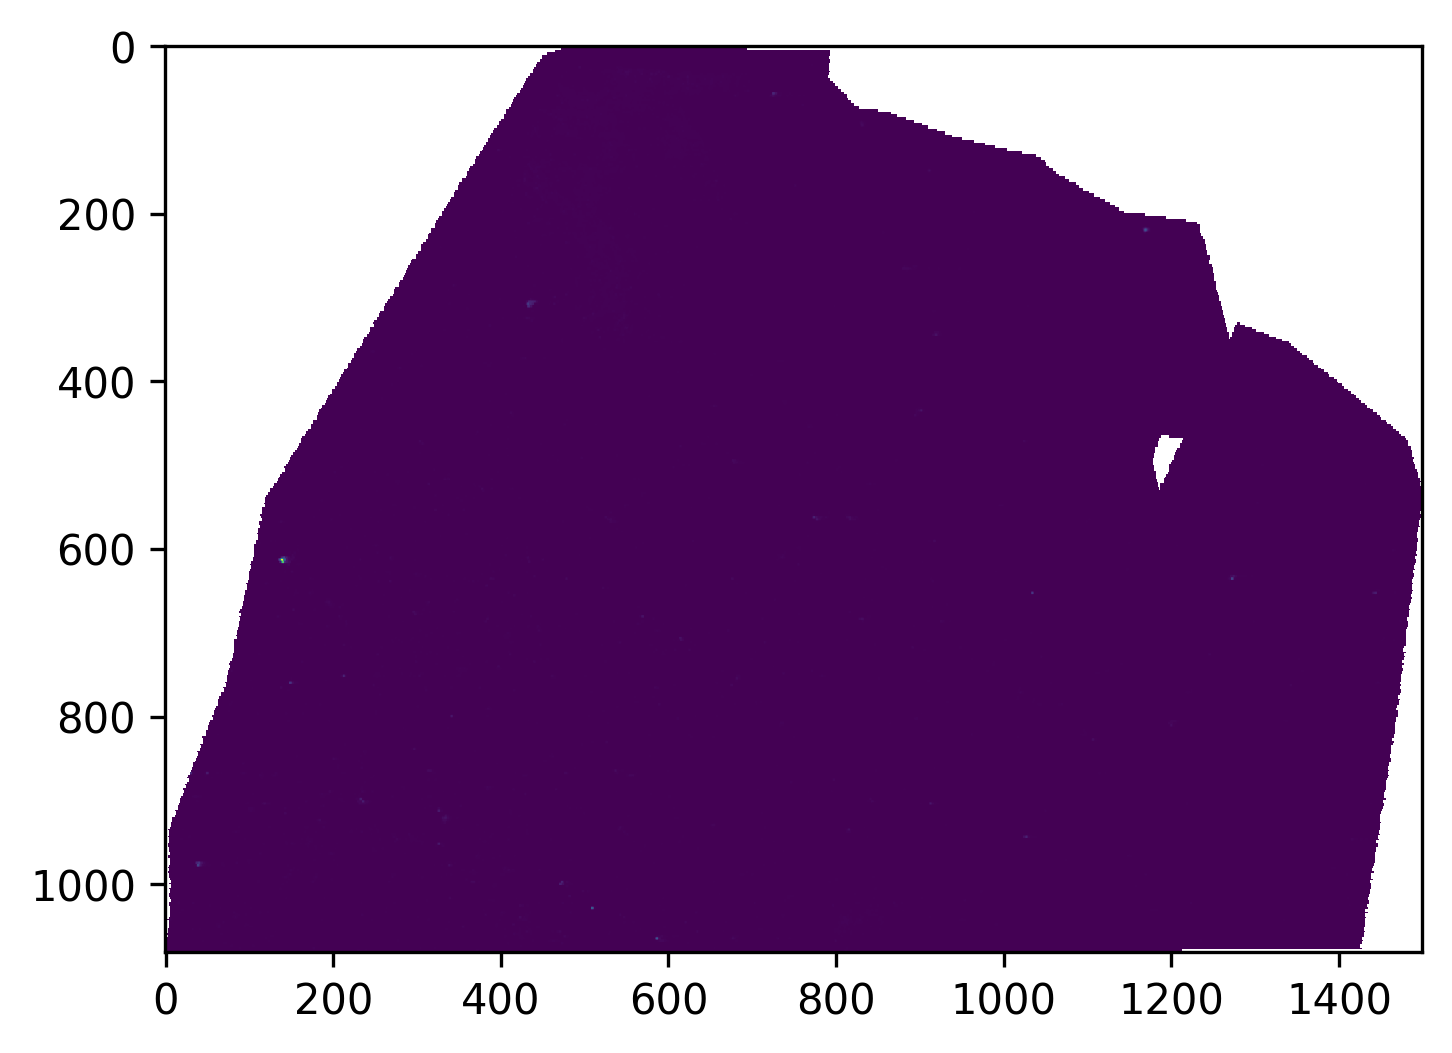

In [65]:
import dash
# import dash_auth
# from users import USERNAME_PASSWORD_PAIRS
from dash import dcc
from dash import html
import plotly
import dash_bootstrap_components as dbc
# import dash_daq as dq
from jupyter_dash import JupyterDash
from dash.exceptions import PreventUpdate
from dash import Dash
import pandas as pd  
import joblib
import base64, io, os
from dash import  dash_table
import dash
import pandas as pd
from dash import dash_table
import pickle
from dash.dependencies import Input, Output, State, ALL, MATCH
import json
# from functools import reduce
from dash import Input, Output, State, html
from tqdm.notebook import trange, tqdm
import pickle
import numpy as np
import pandas as pd
# from cryptography.fernet import Fernet
import json
import io, base64, os
import pandas as pd
import datetime
import time
import re
import plotly.express as px
import plotly.graph_objects as go
from dash_canvas.utils import array_to_data_url
import dash_mantine_components as dmc

import geopandas
import tifffile as tiff
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathpretrain.utils import generate_tissue_mask
import scipy.ndimage as ndimage
from skimage.util import compare_images
from skimage.measure import regionprops_table
from skimage import exposure
import tempfile
import matplotlib.image as mpimg
from skimage import data, draw
from io import BytesIO
import copy
from matplotlib.colors import Normalize as Colors_Normalize
# from scipy import ndimage
from skimage.filters import threshold_otsu
from skimage import morphology as morph
from scipy.ndimage import label as scilabel
from scipy.ndimage.morphology import binary_fill_holes as fill_holes
from skimage import measure
import imageio

import numpy as np
from scipy.ndimage import label, find_objects
from skimage.morphology import remove_small_objects#binary_fill_holes
from skimage import morphology

In [66]:
im_small_crop_annotation_tab = np.full((871, 1499, 3), 255, dtype=np.uint8)
im_small_crop_co = np.full((871, 1499, 3), 255, dtype=np.uint8)
metal_data = {'metals': {'All': np.full((871, 1499), 0.01), 
                         }}

In [67]:
def calculate_mean(arr, x, y):
    # Define the neighboring indices
    neighbors = [(i, j) for i in range(x-1, x+2) for j in range(y-1, y+2) if (i, j) != (x, y)]
    values = []
    
    # Iterate through the neighbors and collect their values
    for i, j in neighbors:
        if 0 <= i < arr.shape[0] and 0 <= j < arr.shape[1]:
            values.append(arr[i, j])

    # Replace NaN values in the list with 0 for mean calculation
    values = [0 if np.isnan(v) else v for v in values]
    
    # Calculate the mean, considering NaNs as 0
    return np.mean(values) if values else np.nan

def replace_nan_with_mean(arr):
    # First create a copy to not alter the original array
    new_arr = np.copy(arr)

    # Boolean array indicating where the NaNs are located
    nan_map = np.isnan(new_arr)

    # While there are NaNs in the array, keep replacing them
    while np.any(nan_map):
        # Iterate over the array
        for x in range(new_arr.shape[0]):
            for y in range(new_arr.shape[1]):
                # Replace NaN with the mean of its neighbors
                if nan_map[x, y]:
                    new_arr[x, y] = calculate_mean(new_arr, x, y)
        
        # Update the NaN map for the next iteration
        nan_map = np.isnan(new_arr)

    return new_arr


In [68]:
def crop_slide(image_array):
#     slide_file = list(filter(lambda x: match_dict[x] == imageId, match_dict))[0]    
    im_large=image_array#tifffile.imread(f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/metals/breast/new_slide_images_4_6_23/{slide_file}.svs")

    tissue_mask=generate_tissue_mask(im_large*5,compression=32.,threshold=240,kernel=10,gray_before_close=True) 
    compression=32
    
    # Metal image is only portion of slide
#     if (imageId == "092619_007_T_HER2"):    
        
#     if (imageId == "102720_003_T_TNBC"):
#         labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
#         lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
#         xmin,ymin,xmax,ymax=(lbl_table.iloc[1][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
#     else:  
    labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
    lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
    xmin,ymin,xmax,ymax=(lbl_table.iloc[0][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
    
    im_large_crop=im_large[xmin:xmax,ymin:ymax].copy()
    im_large_crop[~tissue_mask[xmin:xmax,ymin:ymax]]=255
    
    return im_large_crop, [[xmin, ymin], [xmax, ymax]], tissue_mask

def rescale_no_exposure(im_large_crop, metals_im_gray):
    im_large_crop_gray=cv2.cvtColor(im_large_crop,cv2.COLOR_RGB2GRAY) 
    compression_new=max(im_large_crop_gray.shape)/max(metals_im_gray.shape)
    im_small_crop_gray=cv2.resize(im_large_crop_gray,None,fx=1/compression_new,fy=1/compression_new)
    im_small_crop=cv2.resize(im_large_crop,None,fx=1/compression_new,fy=1/compression_new)
    
    common_size=np.vstack([im_small_crop_gray.shape,metals_im_gray.shape]).max(0)

    im_small_crop_gray_pad=(np.ones(common_size)*np.nan)
    im_small_crop_gray_pad[:im_small_crop_gray.shape[0],:im_small_crop_gray.shape[1]]=im_small_crop_gray
    im_small_crop_gray_pad[np.isnan(im_small_crop_gray_pad)]=255

    metals_im_gray_pad=(np.ones(common_size)*np.nan)
    metals_im_gray_pad[:metals_im_gray.shape[0],:metals_im_gray.shape[1]]=metals_im_gray
    
    padding = common_size - im_small_crop_gray.shape
    
    return im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding

def test_one_point_rotate(x_1, y_1, x_2, y_2, x_1_c, y_1_c, x_2_c, y_2_c):
    if ((x_1-x_1_c)/(x_2-x_2_c))/((y_1-y_1_c)/(y_2-y_2_c)) > 0:
        return 1
    else:
        return -1

def warp_metals(slide_x, slide_y, metals_x, metals_y, dfs_new_df_co):
    warped_metals=dict()   
    for _,(element,element_image) in dfs_new_df_co[['element','image']].iterrows():
        h, w = dfs_new_df_co['image'][0].shape
        metal_k_im_gray_pad = element_image

        slide_x= [275, 197, 1194, 1292, 609]
        slide_y =[116, 949, 328, 753, 702]
        metals_x =[1035, 62, 954, 510, 438]
        metals_y =[127, 237, 1143, 1365, 612]

#         slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
#         slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
#         metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
#         metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
        points_src = []
        points_dst = []
        for i, p in enumerate(slide_x):
            points_dst.append([slide_x[i], slide_y[i]])
            points_src.append([metals_x[i], metals_y[i]])
        points_src = np.array(points_src)
        points_dst = np.array(points_dst)
        homo, status = cv2.findHomography(points_src, points_dst)
        # warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (w, h))
        warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (h, w))
    return warped_metals

def warp_metals_new(slide_x, slide_y, metals_x, metals_y, dfs_new_df_co, hne_shape):
    warped_metals=dict()   
    for _,(element,element_image) in dfs_new_df_co[['element','image']].iterrows():
        h, w = dfs_new_df_co['image'][0].shape
        metal_k_im_gray_pad = element_image

        # slide_x =[583, 415, 2502, 1239, 2409, 1674]
        # slide_y =[245, 2004, 699, 2098, 1906, 334]
        # metals_x =[1026, 82, 953, 141, 513, 1070]
        # metals_y =[121, 175, 1137, 624, 1368, 681]

#         slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
#         slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
#         metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
#         metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
        points_src = []
        points_dst = []
        for i, p in enumerate(slide_x):
            points_dst.append([slide_x[i], slide_y[i]])
            points_src.append([metals_x[i], metals_y[i]])
        points_src = np.array(points_src)
        points_dst = np.array(points_dst)

        homo, status = cv2.findHomography(points_src, points_dst)
        # homo = cv2.getPerspectiveTransform(points_src, points_dst)

        # print('1')
        #identify rotate
        identify_rotate_list = []
        for i_index in range(len(slide_x)):
            marker = test_one_point_rotate(slide_x[i_index], slide_y[i_index], metals_x[i_index], metals_y[i_index], 
                          sum(slide_x)/len(slide_x), sum(slide_y)/len(slide_y), sum(metals_x)/len(metals_x), sum(metals_y)/len(metals_y))
            identify_rotate_list.append(marker)
        # print('11')
        output_h, output_w = hne_shape[0], hne_shape[1]
        # print('111')
        # if output_h/h > output_w/w:
        #     w = output_w/(output_h/h)
        # else:
        #     h = output_h/(output_w/w)
        # print('1111')
        # print(sum(identify_rotate_list))
        # print(w, h)
        # print(int(w), int(h))
        # if sum(identify_rotate_list) > 0:
        #     warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (output_h, output_w))
        # else:
        #     warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (output_w, output_h))
        warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (output_w, output_h))
        # print('shape', warped_metals[element].shape)
        # print('hne_shape', output_h, output_w)
        # array = np.zeros((2000, 2000), dtype=int)f
        # for x, y in zip(metals_x, metals_y):
        #     array[y, x] = 1

        # transformed_src_points = cv2.perspectiveTransform(np.float32([points_src]), m = homo)
        # print('transformed_src_points', transformed_src_points)

        # inverse_matrix = np.linalg.inv(homo)
        # # Convert destination points to a suitable format for perspectiveTransform
        # dst_points_reshaped = np.float32([points_dst])

        # # Apply inverse transformation
        # original_src_points = cv2.perspectiveTransform(dst_points_reshaped, inverse_matrix)
        # print('original_src_points', original_src_points)

        # if sum(identify_rotate_list) > 0:
        #     warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (h, w))
        # else:
        #     warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (w, h))
        # print('11111')
        # warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (w, h)) # original 
        # warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (h, w))
    return warped_metals

In [69]:
# app = JupyterDash(__name__, 
#                   external_stylesheets=[dbc.themes.SPACELAB], 
#                  )

app = Dash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )

history_co_click = 0
file_name_history_1 = ''
file_name_history_2 = ''

history_selected_metal = ''
history_colormap = ''
hitory_vmin = ''
hitory_vmax = ''
history_selected_rows = []
history_co_transport_n_clicks = 99999

last_clickData_hne = {}

last_select_tiff_file = ''
last_select_pkl_file = ''
selected_project = ''

files_to_upload_path = 'None'

project_df_list, file_name_df_list, file_type_list = [], [], []
all_files_list_first = os.listdir('./data/')
all_files_list = []
for one_file in all_files_list_first:
    if one_file == '.DS_Store':
        continue
    else:
        all_files_list.append(one_file)
for one_file in all_files_list:
    data_files_under_list = os.listdir('./data/'+one_file)
    for one_data in data_files_under_list:
        if one_data == '.DS_Store':
            continue
        if 'small' in one_data:
            continue
        if '.svs' in one_data:
            file_type_list.append('H&E')
        elif '.tiff' in one_data:
            file_type_list.append('H&E')
        elif 'pkl' in one_data:
            file_type_list.append('Metals')
        else:
            file_type_list.append('Annotations')
        project_df_list.append(one_file)
        file_name_df_list.append(one_data)
        

files_df = pd.DataFrame({'Project': project_df_list, 
                         'File Name': file_name_df_list, 
                         'File Type': file_type_list,})
display_files_table = dash_table.DataTable(
                                    id='files_table',
                                    columns=[
                                        {"name": i, "id": i,} for i in files_df.columns
                                    ],
                                    data=files_df.to_dict('records'),
                                    row_selectable='multi')




xy_index = []

co_hne_x_list = []
co_hne_y_list = []

fig_hne_co = px.imshow(im_small_crop_annotation_tab)
fig_hne_co.add_scatter(
    x=[],
    y=[],
    mode='markers',
    marker_color='black',
    marker_size=5,
)
fig_hne_co.update_layout(
    template='plotly_dark',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    width=700,#700,
    height=500,#500,
    margin={
        'l': 0,
        'r': 0,
        't': 0,
        'b': 0,
    }
)
fig_hne_co.update_xaxes(visible=False,)
fig_hne_co.update_yaxes(visible=False,)
fig_hne_co.update_coloraxes(showscale=False)



co_metal_x_list = []
co_metal_y_list = []

padded_rows_co = 1000
padded_columns_co = 1600

original_metal_image_co = metal_data['metals']['All']
padded_metal_image_co = original_metal_image_co

cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
padded_metal_image_co = np.log(padded_metal_image_co)+10
padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
replacement_color_to_white_co = np.array([1, 1, 1])
mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

fig_metal_co = px.imshow(padded_metal_image_rgb_co)
fig_metal_co.add_scatter(
    x=[],
    y=[],
    mode='markers+text',
    marker_color='black',
    marker_size=5,
    textposition='top center',
    textfont=dict(color='black'),
)
fig_metal_co.update_layout(
    template='plotly_dark',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    width=700,#700,
    height=500,#500,
    margin={
        'l': 0,
        'r': 0,
        't': 0,
        'b': 0,
    }
)
fig_metal_co.update_xaxes(visible=False,)
fig_metal_co.update_yaxes(visible=False,)
fig_metal_co.update_coloraxes(showscale=False)


original_df_co = pd.DataFrame({'index': xy_index, 
                               'hne x': co_hne_x_list, 'hne y': co_hne_y_list, 
                            'metals x': co_metal_x_list, 'metals y': co_metal_y_list, })

df_co = {'image': [], 'element': [],}
for one_metal in list(metal_data['metals'].keys()):
    df_co['image'].append(metal_data['metals'][one_metal])
    df_co['element'].append(one_metal)
dfs_new_df_co = pd.DataFrame(df_co)


white_image_co = np.ones((100, 100, 3), dtype=np.uint8) * 255
white_fig_co = px.imshow(white_image_co)
white_fig_co.update_xaxes(visible=False,)
white_fig_co.update_yaxes(visible=False,)
white_fig_co.update_coloraxes(showscale=False)
white_fig_co.update_traces(
   hovertemplate=None,
   hoverinfo='skip'
)

xy_coords_table = dash_table.DataTable(
        id='datatable_coord_co',
        columns=[
            {"name": i, "id": i,} for i in original_df_co.columns
        ],
        data=original_df_co.to_dict('records'),
        editable=True, row_deletable=True,)

markdown_text_title = '''
# **Metals Demo**
'''

all_color_list = px.colors.qualitative.Dark24
result_df = pd.DataFrame({'type': [], 'metal': [], 
                              'mean': [], 'std': []})
newest_result_df = pd.DataFrame({'type': [], 'metal': [], 
                              'mean': [], 'std': []})
box_df = pd.DataFrame({'type': [], 'metal': [], 
                              'value': []})

all_relayout_data = {'shapes': [], 'dragmode': ''}

type_to_color_dict = {'immune': all_color_list[0], 'tumor': all_color_list[1]}
color_to_type_dict = {all_color_list[0]: 'immune', all_color_list[1]: 'tumor'}


image_no_axis_layout = go.Layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

def polygon_to_path(polygon, 
                    y_median,
                   ):
    coordinates = polygon.replace("POLYGON ((", "").replace("))", "").split(", ")
    path_points = []
    for coord in coordinates:
        x, y = map(float, coord.split())
        path_points.append(f"{x},{y_median-(y-y_median)}")
    path_string = "M" + "L".join(path_points) + "Z"  # Add "M" at the beginning and "Z" at the end
    
    return path_string

def path_to_indices(path, scale_factor):
    """From SVG path to numpy array of coordinates, each row being a (row, col) point
    """
    indices_str = [
        el.replace("M", "").replace("Z", "").split(",") for el in path.split("L")
    ]
    return np.rint(np.array(indices_str, dtype=float)*(1/scale_factor)).astype(np.int)

def path_to_mask(path, shape, scale_factor, ):
    path_work = path_to_indices(path, scale_factor)
    cols, rows = path_work.T
    rr, cc = draw.polygon(rows, cols)
    mask = np.zeros(shape, dtype=np.bool)
    mask[rr, cc] = True
    mask = ndimage.binary_fill_holes(mask)
    return mask

# FIXME HARDCODED
def parse_contents(contents, filename, date, project_name):
    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)

    read_path = '/Users/luyunrui/Desktop/Dartmouth/metals_app/data/'+str(project_name)+'/'+str(filename)

    try:
        df = geopandas.read_file(read_path)
    except:
        try:
            with open(read_path) as f:
                auto_annot=json.load(f)
                df = gp.GeoDataFrame.from_features(auto_annot)
        except Exception as e:
            print(e)
            return html.Div([
                'There was an error processing this file.'
            ])
    return df

def upload_contents(contents, filename, date, project_name):
    content_type, content_string = contents.split(',')

    decoded = base64.b64decode(content_string)
    # file_path = io.BytesIO(decoded)

    # files_to_upload_path = '/Users/luyunrui/Desktop/Dartmouth/metals_app/metals_app_data/'

    if '.svs' in filename:
        image = tiff.imread(files_to_upload_path+filename)
        com_1 = image.shape[0]/50
        com_2 = image.shape[1]/50
        compressed_image = cv2.resize(image,None,fx=1/min(com_1, com_2),fy=1/min(com_1, com_2))
        # image = tiff.imread(file_path)
        tiff.imwrite('./data/'+project_name+'/'+filename[:-4]+'.tiff', image, photometric='rgb')
        tiff.imwrite('./data/'+project_name+'/'+filename[:-4]+'_small.tiff', compressed_image, photometric='rgb')
    elif '.tiff' in filename:
        image = tiff.imread(files_to_upload_path+filename)
        if image.shape[0] > 10000 or image.shape[1] > 10000:
            com_1 = image.shape[0]/50
            com_2 = image.shape[1]/50
            compressed_image = cv2.resize(image,None,fx=1/min(com_1, com_2),fy=1/min(com_1, com_2))
        # image = tiff.imread(file_path)
        tiff.imwrite('./data/'+project_name+'/'+filename[:-5]+'.tiff', image, photometric='rgb')
        tiff.imwrite('./data/'+project_name+'/'+filename[:-5]+'_small.tiff', compressed_image, photometric='rgb')
    elif '.pkl' in filename:
        with open(files_to_upload_path+filename, "rb") as file:
        # with open(file_path, "rb") as file:
            metal_dict = pickle.load(file)
        # FIXME
        with open('./data/'+project_name+'/'+filename[:-4]+'.pkl', 'wb') as handle:
            pickle.dump(metal_dict, handle)

def output_blank_hne(im_small_crop_annotation_tab):
    blank_figure_hne = go.Figure()

    blank_img_hne_width = im_small_crop_annotation_tab.shape[1]
    blank_img_hne_height = im_small_crop_annotation_tab.shape[0]
    scale_factor = 0.3

    blank_figure_hne.add_trace(
        go.Scatter(
            x=[0, blank_img_hne_width * scale_factor],
            y=[0, blank_img_hne_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )
    blank_figure_hne.update_xaxes(
        visible=False,
        range=[0, blank_img_hne_width * scale_factor]
    )
    blank_figure_hne.update_yaxes(
        visible=False,
        range=[0, blank_img_hne_height * scale_factor],
        scaleanchor="x",
    )
    blank_figure_hne.add_layout_image(
        dict(
            x=0,
            sizex=blank_img_hne_width * scale_factor,
            y=blank_img_hne_height * scale_factor,
            sizey=blank_img_hne_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=array_to_data_url(im_small_crop_annotation_tab))
    )
    blank_figure_hne.update_layout(
        width=blank_img_hne_width * scale_factor,
        height=blank_img_hne_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
    return blank_figure_hne


temp_folder_list = os.listdir('./data/')
temp_folder_list.remove('.DS_Store')

upload_data_card = dbc.Card(
    children = [
        dbc.CardHeader(html.H2("Upload data area")),
        dbc.CardBody(
            [
                dbc.Row([
                dbc.Input(id="upload_data_folder_input", placeholder="Input the upload data folder path", 
                              type="text", 
                              style={'width': '500px'}, 
                             ),
                    dbc.Button("Confirm Upload Data Folder Path", id="confirm_upload_folder_path",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '300px'}, 
                               className="me-1", 
                              ),

                    ], justify='start'
        ),
        dbc.Row([
                html.Div(id='display_upload_folder_path', children = []),
                    ], justify='start'
        ),
                dbc.Row([
                html.Div("Make a new folder: ", style={'font-weight': 'bold'}),
                    ], justify='start'
        ),
                dbc.Row([
                    dbc.Input(id="new_folder_input", placeholder="Input new folder name", 
                              type="text", 
                              style={'width': '250px'}, 
                             ),
                    dbc.Button("Make new folder", id="make_new_folder_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '150px'}, 
                               className="me-1", 
                              ),
                    ], justify='start'
        ),
                dbc.Row([
                    html.Div("Data folder you want upload to: ", style={'font-weight': 'bold'}),
                    dcc.Dropdown(
                    id='upload_data_folder_dropdown',
                    options=temp_folder_list,
                    value=temp_folder_list[0],
                    style={'width': '200px'}, 
                        ),
                    ], justify='start'
        ),
                dbc.Row([
                    html.Div("Upload data: ", style={'font-weight': 'bold'}),
                    dcc.Upload(
                            id='upload_data_files',
                            children=html.Div([
                            'Drag and Drop or ',
                            html.A('Select File')
                            ]),
                            style={
                            'width': '260px',
                            'height': '60px',
                            'lineHeight': '60px',
                            'borderWidth': '1px',
                            'borderStyle': 'dashed',
                            'borderRadius': '5px',
                            'textAlign': 'center',
                            'margin': '10px'
                             },
                            multiple=False
                            ),
                    ], justify='start'
        ), 
            ]
        ),
        dbc.CardFooter([
            dbc.Row([
                    html.Div("Upload multiple metals xlsx files and concat to pkl file: ", style={'font-weight': 'bold'}),
                    dcc.Upload(
                            id='upload_multiple_xlsx_files',
                            children=html.Div([
                            'Drag and Drop or ',
                            html.A('Select metals xlsx Files')
                            ]),
                            style={
                            'width': '320px',
                            'height': '60px',
                            'lineHeight': '60px',
                            'borderWidth': '1px',
                            'borderStyle': 'dashed',
                            'borderRadius': '5px',
                            'textAlign': 'center',
                            'margin': '10px'
                             },
                            multiple=True,
                            ),
                    ], justify='start'
        ), 
        ]),
    ]
)

data_display_table_card = dbc.Card(
    children = [
        dbc.CardHeader(html.H2("Display data table")),
        dbc.CardBody(
            [
                dbc.Row([
                    html.Div(id='display_data_table_container', children = [display_files_table])
                # display_files_table,
                ], justify='start'
        ),
                
                            ]
        ),
        dbc.CardFooter(
            [dbc.Row([
                # button
                dbc.Button("Load Selected Data", id="load_data_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '200px'}, 
                               className="me-1", 
                              ),
                    # html.Div(id='display_data_table_container', children = [display_files_table])
                # display_files_table,
                ], justify='start'
        ),
                dbc.Row([
                html.Div(id='output_selected_file', children = [])
                ], justify='start'
        ),
            ]),
        
    ]
)



blank_figure_hne = output_blank_hne(im_small_crop_annotation_tab)

padded_rows = 1000
padded_columns = 1600

original_metal_image = metal_data['metals']['All']
rows_padding = max(0, padded_rows - original_metal_image.shape[0])
columns_padding = max(0, padded_columns - original_metal_image.shape[1])
top_pad = rows_padding // 2
bottom_pad = rows_padding - top_pad
left_pad = columns_padding // 2
right_pad = columns_padding - left_pad
padded_metal_image = original_metal_image

cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image[padded_metal_image <= 0] = 0.000001
padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
padded_metal_image = np.log(padded_metal_image)+10
padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]

blank_figure = go.Figure()

blank_img_width = padded_metal_image.shape[1]
blank_img_height = padded_metal_image.shape[0]
scale_factor = 0.3

blank_figure.add_trace(
    go.Scatter(
        x=[0, blank_img_width * scale_factor],
        y=[0, blank_img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

blank_figure.update_xaxes(
    visible=False,
    range=[0, blank_img_width * scale_factor]
)

blank_figure.update_yaxes(
    visible=False,
    range=[0, blank_img_height * scale_factor],
    scaleanchor="x",
)
    
blank_figure.add_layout_image(
    dict(
        x=0,
        sizex=blank_img_width * scale_factor,
        y=blank_img_height * scale_factor,
        sizey=blank_img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
)

blank_figure.update_layout(
    width=blank_img_width * scale_factor,
    height=blank_img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

image_annotation_card = dbc.Card(
    children = [dbc.CardHeader(html.H2("Annotation area")),
        dbc.CardBody(
            [
                dcc.Graph(
                    id="annotate_metal_image",
                    figure=blank_figure,
                    config={"modeBarButtonsToAdd": ["drawrect", "eraseshape", "drawclosedpath",], 
                            'modeBarButtonsToRemove': [
                                                        'zoom2d', 
                                                       'pan2d', 
                                                       'zoomIn2d', 'zoomOut2d', 
                                                        ]},
                ),
                dcc.Store(id='annotation_store', data=[]),
                dbc.Row([
                    html.Div("color map and metals: ", style={'font-weight': 'bold'}),
                ]),
                dbc.Row([
                    dcc.Dropdown(
                                id='annotation_colormap',
                                options=[{'label': 'viridis', 'value': 'viridis'}, 
                                         {'label': 'jet', 'value': 'jet'}, 
                                         {'label': 'plasma', 'value': 'plasma'}],
                                value='jet',
                                style={'width': '150px'}, 
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_annotation',
                                options=['All'],
                                value='All',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                ], justify="start",),
                dbc.Row([
                    html.Div("vmin and vmax: ", style={'font-weight': 'bold'}),
                    dcc.RangeSlider(0, 100, value=[0, 100], id="vmin_vmax_input",
                                    marks={
                                        0: {'label': '0%', 'style': {'color': '#f50'}},
                                        100: {'label': '100%', 'style': {'color': '#f50'}},
                                    },
                                    pushable=1,
                                    included=False,
                               tooltip={"placement": "bottom", "always_visible": True},
                                ),
                    ], justify="start",),
            ]
        ),
        dbc.CardFooter(
            [
                dcc.Markdown(
                    "To annotate the above image"
                    "\n\n"
                    "**Choose type**:"
                ),
                dbc.Row([
                    dbc.Input(id="type_input", placeholder="Add new type", 
                              type="text", 
                              style={'width': '170px'}, 
                             ),
                    dbc.Button("Add Type", id="add_type_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '100px'}, 
                               className="me-1", 
                              ),
                    dcc.Dropdown(
                                id='type_dropdown_annotation',
                                options=['immune', 'tumor'],
                                value='immune',
                                style={'width': '300px'}, 
                                    ),]),
                dcc.Markdown(
                    "**Click to Calculate Results**:"
                ),
                dbc.Row([
                    dbc.Button('Calculate Result', id='update_table_button', 
                           n_clicks=0, className="me-1", style={'width': '150px'}, ), 
                ], justify="start",),
            ]
        ),]
)

annotation_result_table = dash_table.DataTable(
    data=result_df.to_dict('records'),
    columns=[{'id': c, 'name': c} for c in result_df.columns],
    fixed_rows={'headers': True},
    style_table={'height': 400, 'overflowY': 'auto'}  # defaults to 500
)

table_result_content = dbc.Card(
    children = [dbc.CardHeader(html.H2("Table")),
        dbc.CardBody(
            [
                dbc.Row([
                html.Div(id='table_container', children = annotation_result_table),
                ]),
            ]
        ),
        dbc.CardFooter(
            [
                dbc.Button("Download Table", id="export_data",
                           size="sm", n_clicks=0, className="me-1"),
                dcc.Download(id="download_dataframe_csv"),
            ]
        ),]
)

boxplot_result_content = dbc.Card(
    children = [dbc.CardHeader(html.H2("Boxplot")),
        dbc.CardBody(
            [
                dbc.Row([
                dcc.Graph(id="result_boxplot"),
                dmc.Switch(id="boxplot_metal_type", label="Metals/Annotations", checked=False),
                dmc.Switch(id="boxplot_log_scale", label="Log Scale Boxplot", checked=True),
                dcc.Dropdown(
                                id='boxplot_dropdown',
                                options=['All'],
                                value='All',
                                style={'width': '300px'}, 
                                    ),
                ]),
            ]
        ),
        dbc.CardFooter([]),]
)

table_boxplot_tabs = dbc.Tabs(
    [
        dbc.Tab(table_result_content, label="Table"),
        dbc.Tab(boxplot_result_content, label="Boxplot"),
    ]
)


default_type_color_match_list = []
default_color_to_type_dict = {'#2E91E5': 'immune', '#E15F99': 'tumor'}
for one_color in list(default_color_to_type_dict.keys()):
    new_line = html.P(
        [
            str(default_color_to_type_dict[one_color]),': ',
            html.Span("", style={"background-color": one_color, "width": "15px", "height": "15px", "display": "inline-block", "vertical-align": "middle"}),
            f" {one_color}."
        ],
        style={"display": "flex", "align-items": "center"}
    )
    default_type_color_match_list.append(new_line)

annotation_hne_card = dbc.Card(
    children = [dbc.CardHeader(html.H2("H&E")),
        dbc.CardBody(
            [
                dbc.Row([
                dcc.Graph(id="blank_hne_image", figure=blank_figure_hne),
                ]),
            ]
        ),
        dbc.CardFooter(
            [
                dbc.Row([
                        html.Div(id="type_color_match_list", children=default_type_color_match_list),
                        dcc.Upload(
                                id='upload_annotation',
                                children=html.Div([
                                'Drag and Drop or ',
                                html.A('Select Files')
                                ]),
                                style={
                                'width': '260px',
                                'height': '60px',
                                'lineHeight': '60px',
                                'borderWidth': '1px',
                                'borderStyle': 'dashed',
                                'borderRadius': '5px',
                                'textAlign': 'center',
                                'margin': '10px'
                                    },
                                multiple=False
                                ),
                        ], justify="center",),
            ]
        ),]
)

image_annotation_table = dbc.Row(
                                [
                                dbc.Col(annotation_hne_card, width=4),
                                dbc.Col(image_annotation_card, width=5),
                                # dbc.Col(annotated_data_card, md=3),
                                dbc.Col(table_boxplot_tabs, md=3),
                                ], 
                                justify="start",)

tab_Measure_content = dbc.Card(
    dbc.CardBody(
        [
            image_annotation_table,
        ]
    ),
    className="mt-3",)


all_coregister_content = dbc.Container(
    [
        dbc.Row(
            [dbc.Col(
                dcc.Graph(
                    id='graph_hne_co',
                    figure=fig_hne_co,
                    config={
                        'displayModeBar': False,
                    }
                ),
                width={'size': 5, 'offset': 0}
            ),
             dbc.Col(
                 html.Div(children = [
                     dcc.Graph(
                    id='graph_metal_co',
                    figure=fig_metal_co,
                    config={'displayModeBar': False,}),
                     dbc.Row([
                    html.Div("color map and metals: ", style={'font-weight': 'bold'}),
                ]),
                     dbc.Row(
                     [dcc.Dropdown(
                                id='metal_colormap_co',
                                options=['jet', 'viridis', 'plasma'],
                                value='jet',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_co',
                                options=['All'],
                                value='All',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),], justify='center'),
                     dbc.Row([
                    html.Div("vmin and vmax: ", style={'font-weight': 'bold'}),
                ]),
                     dcc.RangeSlider(0, 100, value=[0, 100], id="vmin_vmax_input_co",
                                    marks={
                                        0: {'label': '0%', 'style': {'color': '#f50'}},
                                        100: {'label': '100%', 'style': {'color': '#f50'}},
                                    },
                                    pushable=1,
                                    included=False,
                               tooltip={"placement": "bottom", "always_visible": True},
                                ),
                 ],
                 ),
                width={'size': 5, 'offset': 0}
            ),
    ], justify='between'
        ),
        dbc.Row(
            [
                dbc.Col(
                html.Div(id='table_container_co', children = xy_coords_table), width={'size': 6,}),
        ], justify='center'),
        dbc.Row(
            [
                dbc.Button('Start Coregister', id="start_co_button", style={'width': '160px'}, n_clicks=0),
                ], justify='center'),
        dbc.Row(
            [
                html.Div(id='two_image_container', children=[]),
                ], justify='center'),
        dbc.Row(
            [
                dcc.Graph(id='check_border_image', figure = white_fig_co, config={'displayModeBar': False,}),
                ], justify='center'),
    ], fluid=True
)


tab_Coregister_content = dbc.Card(
    dbc.CardBody(
        [
            all_coregister_content,
        ]
    ),
    className="mt-3",)

full_upload_data_card = dbc.Row(
                                [
                                dbc.Col(upload_data_card, width=6),
                                dbc.Col(data_display_table_card, md=6),
                                ], 
                                justify="evenly",)

tab_Data_content = dbc.Card(
    dbc.CardBody(
        [
            full_upload_data_card,
        ]
    ),
    className="mt-3",)


all_preprocess_content = dbc.Container(
    [
        dbc.Row(
            [
             dbc.Col(
                 html.Div(children = [
                     dcc.Graph(
                    id='metal_pre',
                    figure=blank_figure,
                    config={'displayModeBar': False,}),
                     dbc.Row([
                    html.Div("color map and metals: ", style={'font-weight': 'bold'}),
                ]),
                     dbc.Row(
                     [dcc.Dropdown(
                                id='metal_colormap_pre',
                                options=['jet', 'viridis', 'plasma'],
                                value='jet',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_pre',
                                options=['All'],
                                value='All',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),], justify='center'),
                     dbc.Row([
                    html.Div("vmin and vmax: ", style={'font-weight': 'bold'}),
                ]),
                     dcc.RangeSlider(0, 100, value=[0, 100], id="vmin_vmax_input_pre",
                                    marks={
                                        0: {'label': '0%', 'style': {'color': '#f50'}},
                                        100: {'label': '100%', 'style': {'color': '#f50'}},
                                    },
                                    pushable=1,
                                    included=False,
                               tooltip={"placement": "bottom", "always_visible": True},
                                ),
                    # dbc.Button('Generate Mask', id="start_generate_mask_button", style={'width': '200px'}, n_clicks=0),
                 ],
                 ),
                width={'size': 5, 'offset': 0}
            ),
            dbc.Col(html.Div(children = [
                dcc.Graph(
                    id='metal_pre_mask',
                    figure=blank_figure,
                    config={
                        'displayModeBar': False,
                    }
                ),
                html.Div("Select threshold percentage: it will include all value below this threshold", style={'font-weight': 'bold'}),
                dcc.Slider(0, 255, 1, id="pre_threshold_input", value=90, marks=None,tooltip={"placement": "bottom", "always_visible": True}),
                dbc.Button('Generate Mask', id="start_generate_mask_button", style={'width': '200px'}, n_clicks=0),]),
                width={'size': 5, 'offset': 0},
            ),
    ], justify='between'
        ),
        # dbc.Row(
        #     [
        #         dbc.Col(
        #         html.Div(id='table_container_co', children = xy_coords_table), width={'size': 6,}),
        # ], justify='center'),
        # dbc.Row(
        #     [
        #         dbc.Button('Start Coregister', id="start_co_button", style={'width': '160px'}, n_clicks=0),
        #         ], justify='center'),
        # dbc.Row(
        #     [
        #         html.Div(id='two_image_container', children=[]),
        #         ], justify='center'),
        # dbc.Row(
        #     [
        #         dcc.Graph(id='check_border_image', figure = white_fig_co, config={'displayModeBar': False,}),
        #         ], justify='center'),
    ], fluid=True
)


tab_Preprocess_content = dbc.Card(
    dbc.CardBody(
        [
            all_preprocess_content,
        ]
    ),
    className="mt-3",)


all_tabs = dbc.Tabs(
    [
        dbc.Tab(tab_Data_content, label="Data"),
        dbc.Tab(tab_Preprocess_content, label="Preprocess"),
        dbc.Tab(tab_Coregister_content, label="Co-register"),
        dbc.Tab(tab_Measure_content, label="Measure"),
    ]
)

app.layout = html.Div([dcc.Markdown(children=markdown_text_title),
                       all_tabs])


@app.callback(
    Output('metal_pre_mask', 'figure', allow_duplicate=True),
    Output('display_data_table_container', 'children', allow_duplicate=True),
    # Output('files_table', 'selected_rows', allow_duplicate=True),
    Input('start_generate_mask_button', 'n_clicks'),
    State('pre_threshold_input', 'value'),
    State('files_table', 'selected_rows'),
    prevent_initial_call=True,
)
def generate_tissue_mask_func(n_clicks, threshold, old_selected_rows):

    if n_clicks > 0:
        scale_factor = 0.25

        all_metals = original_metal_data['metals']['All']

        # png_file_path = './data/'+str(selected_project)+'/'+str(select_pkl_file)[:-4]+'.npy'
        # print('png_file_path', png_file_path)

        # if not os.path.exists(png_file_path):
        image = replace_nan_with_mean(all_metals)
        imageio.imwrite('tissue_mask_test.png', np.log(image+5))
        image = cv2.imread('tissue_mask_test.png', 0)
    # plt.imshow(image)
        blurred = cv2.GaussianBlur(image, (1, 1), 0)
        #     with open(png_file_path, 'wb') as f:
        #         np.save(f, blurred)
        # else:
        #     print('save time')
        #     with open(png_file_path, 'rb') as f:
        #         blurred = np.load(f)

        thresh = threshold
        _, tissue_mask = cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((1,1),np.uint8)
        tissue_mask = cv2.morphologyEx(tissue_mask, cv2.MORPH_OPEN, kernel)
        tissue_mask = cv2.morphologyEx(tissue_mask, cv2.MORPH_CLOSE, kernel)
        # plt.imshow(tissue_mask)
        # plt.show()

        test_1 = morphology.remove_small_holes(tissue_mask, 10000)
        # plt.imshow(test_1)
        # plt.show()
        final_mask = morphology.remove_small_objects(test_1, 50000)

        print(np.sum(final_mask))

        final_mask = ~final_mask

        print(np.sum(final_mask))

        # original_metal_data_store = original_metal_data.copy()

        # for one_key in list(original_metal_data['metals'].keys()):
        #     original_metal_data_store['metals'][one_key][~final_mask] = np.nan

        # dump_path = './data/'+str(selected_project)+'/proprocess_metals.pkl'

        # with open(dump_path, 'wb') as handle:
        #     pickle.dump(original_metal_data_store, handle)

        # with open('final_mask_pre.npy', 'wb') as f:
        #     np.save(f, final_mask)
            # np.save(f, np.array([1, 3]))


        # plt.imshow(test_2)
        # plt.show()
        # print('final_mask', final_mask)
        # print(final_mask[500, 600])
        # print(final_mask[600, 600])
        # print(final_mask[500, 500])
        # print(final_mask.sum())

        # threshold = int(255*threshold*0.01)

        # append_count = 0
        # for i_index in list(metal_data['metals'].keys()):
        #     i = metal_data['metals'][i_index]
        #     if append_count == 0:
        #         # i[i <= 0] = 0.000001
        #         # i = np.nan_to_num(i, nan=0.000001)
        #         all_metals = i
        #         continue
        #     # i[i <= 0] = 0.000001
        #     # i = np.nan_to_num(i, nan=0.000001)
        #     all_metals += i
        #     append_count += 1

        # # metal_image = metal_data['metals']['Ca44']
        # # all_metals[all_metals <= 0] = 0.000001
        # # all_metals = np.nan_to_num(all_metals, nan=0.000001)

        # padded_metal_image = all_metals
        # padded_metal_image[padded_metal_image <= 0] = 0.000001
        # padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
        # padded_metal_image = np.log(padded_metal_image)+10
        # # if vmin and vmax:
        # #     c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image, vmin), 
        # #                             vmax=np.percentile(padded_metal_image, vmax), clip=True)
        # #     padded_metal_image_normalized = c_norm(padded_metal_image)
        # # else:
        # padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
        # cmap_jet = plt.cm.get_cmap('jet')
        # padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)



        # padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        # target_color_to_white = padded_metal_image_rgb[0, 0, :]
        # replacement_color_to_white = np.array([1, 1, 1])
        # mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        # padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        # padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        # target_color_to_white = padded_metal_image_rgb[-1, 0, :]
        # replacement_color_to_white = np.array([1, 1, 1])
        # mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        # padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        # padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        # target_color_to_white = padded_metal_image_rgb[0, -1, :]
        # replacement_color_to_white = np.array([1, 1, 1])
        # mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        # padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        # padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        # target_color_to_white = padded_metal_image_rgb[-1, -1, :]
        # replacement_color_to_white = np.array([1, 1, 1])
        # mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        # padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        # cv2.imwrite('preprocess_test.jpg', (padded_metal_image_rgb*255).astype(int))
        # padded_metal_image_rgb = cv2.imread('preprocess_test.jpg')

        # # FIXME custom mask function on metals not RGB image because will be highly dependent on color scale
        # # FIXME remove pathpretrain dependency
        # # just copy code and use raw 2D array

        # final_mask=generate_tissue_mask(padded_metal_image_rgb,compression=1,threshold=threshold,kernel=10,gray_before_close=True, keep_holes = False)

        # final_mask = generate_tissue_mask(all_metals, compression = 0.5, keep_holes = False, )

        # print('final_shape', final_mask.shape)

        # red_color = np.array([255, 0, 0], dtype=np.uint8)  # Red
        # blue_color = np.array([0, 0, 255], dtype=np.uint8)  # Blue

        # # Create an empty RGB array with the same shape as the boolean array
        # height, width = final_mask.shape
        # rgb_array = np.zeros((height, width, 3), dtype=np.uint8)

        # # Assign red or blue color based on the boolean values
        # rgb_array[final_mask] = blue_color  # Assign blue where True
        # rgb_array[~final_mask] = red_color  # Assign red where False

        contours = measure.find_contours(final_mask, 0.5)

        # print('contours', contours)

        # def polygon_to_path(polygon, 
        #                     y_median,
        #                 ):
        #     coordinates = polygon.replace("POLYGON ((", "").replace("))", "").split(", ")
        #     path_points = []
        #     for coord in coordinates:
        #         x, y = map(float, coord.split())
        #         path_points.append(f"{x},{y_median-(y-y_median)}")
        #     path_string = "M" + "L".join(path_points) + "Z"  # Add "M" at the beginning and "Z" at the end
            
        #     return path_string
        # FIXME scikiy image, draw polygon function generates mask from polygon of outline
        padded_metal_image = all_metals
        padded_metal_image[padded_metal_image <= 0] = 0.000001
        padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
        padded_metal_image = np.log(padded_metal_image)+10
        # if vmin and vmax:
        #     c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image, vmin), 
        #                             vmax=np.percentile(padded_metal_image, vmax), clip=True)
        #     padded_metal_image_normalized = c_norm(padded_metal_image)
        # else:
        padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
        cmap_jet = plt.cm.get_cmap('jet')
        padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)



        padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        target_color_to_white = padded_metal_image_rgb[0, 0, :]
        replacement_color_to_white = np.array([1, 1, 1])
        mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        target_color_to_white = padded_metal_image_rgb[-1, 0, :]
        replacement_color_to_white = np.array([1, 1, 1])
        mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        target_color_to_white = padded_metal_image_rgb[0, -1, :]
        replacement_color_to_white = np.array([1, 1, 1])
        mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        target_color_to_white = padded_metal_image_rgb[-1, -1, :]
        replacement_color_to_white = np.array([1, 1, 1])
        mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        cv2.imwrite('preprocess_test.jpg', (padded_metal_image_rgb*255).astype(int))
        padded_metal_image_rgb = cv2.imread('preprocess_test.jpg')

        print('contours', contours)

        fig, ax = plt.subplots()
        ax.imshow(padded_metal_image_rgb, cmap=plt.cm.jet)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="blue")

        ax.axis('image')
        ax.set_axis_off()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.margins(0,0)
        plt.savefig('mask_contour.jpg', dpi = 1200, bbox_inches='tight')
        plt.close()
        # plt.show()

        contour_image = cv2.imread('mask_contour.jpg')

        
        # def contour_to_polygon(contour):
        #     final_polygon = 'POLYGON (('
        #     for one_point in contour:
        #         final_polygon += str(one_point[0])
        #         final_polygon += ' '
        #         final_polygon += str(one_point[1])
        #         final_polygon += ', '
        #     final_polygon = final_polygon[:-2]
        #     final_polygon += '))'
        #     return final_polygon

        # # mask_polygon = contour_to_polygon(contour)
        # # print(contours)
        # # print(contour_to_polygon(contours))
        # # print(metal_data['metals'][list(metal_data['metals'].keys())[0]].shape[0]*0.5*scale_factor)
        # mask_path = polygon_to_path(contour_to_polygon(contours[0]), metal_data['metals'][list(metal_data['metals'].keys())[0]].shape[0]*0.5*scale_factor)
        # print(mask_path)

        blank_figure_mask = go.Figure()

        # blank_figure_mask_width = metal_data['metals'][list(metal_data['metals'].keys())[0]].shape[1]
        # blank_figure_mask_height = metal_data['metals'][list(metal_data['metals'].keys())[0]].shape[0]

        blank_figure_mask_width = contour_image.shape[1]
        blank_figure_mask_height = contour_image.shape[0]

        scale_factor = (metal_data['metals'][list(metal_data['metals'].keys())[0]].shape[1]/contour_image.shape[1])*0.32

        blank_figure_mask.add_trace(
            go.Scatter(
                x=[0, blank_figure_mask_width * scale_factor],
                y=[0, blank_figure_mask_height * scale_factor],
                mode="markers",
                marker_opacity=0
            )
        )
        blank_figure_mask.update_xaxes(
            visible=False,
            range=[0, blank_figure_mask_width * scale_factor]
        )
        blank_figure_mask.update_yaxes(
            visible=False,
            range=[0, blank_figure_mask_height * scale_factor],
            scaleanchor="x",
        )
        blank_figure_mask.add_layout_image(
            dict(
                x=0,
                sizex=blank_figure_mask_width * scale_factor,
                y=blank_figure_mask_height * scale_factor,
                sizey=blank_figure_mask_height * scale_factor,
                xref="x",
                yref="y",
                opacity=1.0,
                layer="below",
                sizing="stretch",
                source=array_to_data_url(contour_image),)
        )
        blank_figure_mask.update_layout(
            width=blank_figure_mask_width * scale_factor,
            height=blank_figure_mask_height * scale_factor,
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
        )

        # append_relayout = {'editable': True, 
        #                        'fillcolor': 'rgba(0, 0, 0, 0)', 
        #                        'fillrule': 'evenodd', 
        #                        'layer': 'above', 
        #                        'line': {'color': all_color_list[1], 'dash': 'solid', 'width': 2}, 
        #                        'opacity': 1, 'type': 'path', 
        #                        'xref': 'x', 'yref': 'y', 
        #                        'path': mask_path}
        # all_relayout_data = {'shapes': [append_relayout], 
        #                     #  'dragmode': 'drawclosedpath',
        #                      }
        # #     if append_relayout not in all_relayout_data['shapes']:
        # #         all_relayout_data['shapes'].append(append_relayout)
        # # all_relayout_data['dragmode'] = 'drawclosedpath'
        # blank_figure_mask['layout'].update(all_relayout_data)

        
        
        # original_metal_data_copy = original_metal_data.copy()

        plt.imshow(metal_data_preprocess['metals']['All'])

        for one_key in list(metal_data_preprocess['metals'].keys()):
            metal_data_preprocess['metals'][one_key][~final_mask] = np.nan

        dump_path = './data/'+str(selected_project)+'/preprocess_metals.pkl'

        # with open(dump_path, 'wb') as handle:
        #     pickle.dump(metal_data_preprocess, handle)

        project_df_list, file_name_df_list, file_type_list = [], [], []
        all_files_list_first = os.listdir('./data/')
        all_files_list = []
        for one_file in all_files_list_first:
            if one_file == '.DS_Store':
                continue
            else:
                all_files_list.append(one_file)
        for one_file in all_files_list:
            data_files_under_list = os.listdir('./data/'+one_file)
            for one_data in data_files_under_list:
                if one_data == '.DS_Store':
                    continue
                if 'small' in one_data:
                    continue
                if '.svs' in one_data:
                    file_type_list.append('H&E')
                elif '.tiff' in one_data:
                    file_type_list.append('H&E')
                elif 'pkl' in one_data:
                    file_type_list.append('Metals')
                else:
                    file_type_list.append('Annotations')
                project_df_list.append(one_file)
                file_name_df_list.append(one_data)

        two_files_name_list = []
        for one_index in old_selected_rows:
            two_files_name_list.append(project_df_list[one_index]+file_name_df_list[one_index])
        print('len(project_df_list)', len(project_df_list), project_df_list)
        with open(dump_path, 'wb') as handle:
            pickle.dump(metal_data_preprocess, handle)
        
        project_df_list, file_name_df_list, file_type_list = [], [], []
        all_files_list_first = os.listdir('./data/')
        all_files_list = []
        for one_file in all_files_list_first:
            if one_file == '.DS_Store':
                continue
            else:
                all_files_list.append(one_file)
        for one_file in all_files_list:
            data_files_under_list = os.listdir('./data/'+one_file)
            for one_data in data_files_under_list:
                if one_data == '.DS_Store':
                    continue
                if 'small' in one_data:
                    continue
                if '.svs' in one_data:
                    file_type_list.append('H&E')
                elif '.tiff' in one_data:
                    file_type_list.append('H&E')
                elif 'pkl' in one_data:
                    file_type_list.append('Metals')
                else:
                    file_type_list.append('Annotations')
                project_df_list.append(one_file)
                file_name_df_list.append(one_data)
        print('new len(project_df_list)', len(project_df_list), project_df_list)
        print('two_files_name_list', two_files_name_list)
        # print()
        new_selected_rows = []
        for one_index in range(len(project_df_list)):
            if (project_df_list[one_index] + file_name_df_list[one_index]) in two_files_name_list:
                new_selected_rows.append(one_index)

        files_df = pd.DataFrame({'Project': project_df_list, 
                                'File Name': file_name_df_list, 
                                'File Type': file_type_list,})

        display_files_table = dash_table.DataTable(
                                    id='files_table',
                                    selected_rows = new_selected_rows,
                                    columns=[
                                        {"name": i, "id": i,} for i in files_df.columns
                                    ],
                                    data=files_df.to_dict('records'),
                                    row_selectable='multi')

        print('old_selected_rows', old_selected_rows)
        print('new_selected_rows', new_selected_rows)
        

        return blank_figure_mask, [display_files_table]#, []
    else:
        raise PreventUpdate


@app.callback(
    Output('metal_pre', 'figure'),
    Output('metal_pre_mask', 'figure'),
    Input('metal_colormap_pre', 'value'),
    Input('metal_dropdown_pre', 'value'),
    Input('vmin_vmax_input_pre', 'value'),
)           
def update_pre_metals(colormap, selected_metal, vmin_vmax):
    vmin, vmax = vmin_vmax[0], vmin_vmax[1]

    if selected_metal == 'All':
        append_count = 0
        for i_index in list(metal_data['metals'].keys()):
            i = metal_data['metals'][i_index]
            if append_count == 0:
                all_metals = i
                continue
            all_metals += i
            append_count += 1
        original_metal_image = all_metals
    else:
        original_metal_image = metal_data['metals'][selected_metal]
    padded_metal_image = original_metal_image
    padded_metal_image[padded_metal_image <= 0] = 0.000001
    padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
    padded_metal_image = np.log(padded_metal_image)+10
    if vmin and vmax:
        c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image, vmin), 
                                vmax=np.percentile(padded_metal_image, vmax), clip=True)
        padded_metal_image_normalized = c_norm(padded_metal_image)
    else:
        padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
    cmap_jet = plt.cm.get_cmap(colormap)
    padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
    padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
    target_color_to_white = padded_metal_image_rgb[0, 0, :]
    replacement_color_to_white = np.array([1, 1, 1])
    mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
    padded_metal_image_rgb[mask_to_white] = replacement_color_to_white
    blank_figure = go.Figure()

    blank_img_width = original_metal_image.shape[1]
    blank_img_height = original_metal_image.shape[0]
    scale_factor = 0.3

    blank_figure.add_trace(
        go.Scatter(
            x=[0, blank_img_width * scale_factor],
            y=[0, blank_img_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )
    blank_figure.update_xaxes(
        visible=False,
        range=[0, blank_img_width * scale_factor]
    )
    blank_figure.update_yaxes(
        visible=False,
        range=[0, blank_img_height * scale_factor],
        scaleanchor="x",
    )
    blank_figure.add_layout_image(
        dict(
            x=0,
            sizex=blank_img_width * scale_factor,
            y=blank_img_height * scale_factor,
            sizey=blank_img_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
    )
    blank_figure.update_layout(
        width=blank_img_width * scale_factor,
        height=blank_img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
    return blank_figure, blank_figure


@app.callback(
    Output('display_upload_folder_path', 'children'),
    Input('confirm_upload_folder_path', 'n_clicks'),
    Input('upload_data_folder_input', 'value'),
)

def confirm_upload_file_path(n_clicks, file_path):
    global files_to_upload_path
    if n_clicks > 0:
        if file_path != None:
            # if file_path
            files_to_upload_path = str(file_path)
            if files_to_upload_path[-1] != '/':
                files_to_upload_path += '/'

    new_line = html.P(
                        [str(files_to_upload_path), ' is file upload path'],
                        style={"display": "flex", "align-items": "center"}
                    )
    
    return new_line

@app.callback(
    Output('upload_data_folder_dropdown', 'options'),
    Input('make_new_folder_button', 'n_clicks'),
    State('new_folder_input', 'value'),
    State('upload_data_folder_dropdown', 'options'),
)

def make_new_folder(n_clicks, new_folder_input, upload_data_folder_dropdown):
    if n_clicks > 0:
        if new_folder_input != None:
            if new_folder_input not in upload_data_folder_dropdown:
                os.mkdir('./data/'+new_folder_input)
                upload_data_folder_dropdown.append(new_folder_input)
    return upload_data_folder_dropdown
    

@app.callback(
    Output('files_table', 'data', allow_duplicate=True),
    Input('upload_multiple_xlsx_files', 'contents'),
    State('upload_data_folder_dropdown', 'value'),
    State('upload_multiple_xlsx_files', 'filename'),
    State('upload_multiple_xlsx_files', 'last_modified'),
    prevent_initial_call=True,
)

def upload_file(list_of_contents, upload_data_folder_dropdown, list_of_names, list_of_dates):
    temp_metal_dict = {}

    if list_of_contents is not None:
        # print(len(list_of_contents))
        # print(len(list_of_names))
        # print(len(list_of_dates))
        # print(list_of_contents)
        # print(list_of_names)
        # print(list_of_dates)
        for contents, filename, last_modified in zip(list_of_contents, list_of_names, list_of_dates):
            content_type, content_string = contents.split(',')
            decoded = base64.b64decode(content_string)

            df = pd.read_excel(io.BytesIO(decoded))

            split_string = filename.split()
            if 'ppm' in split_string[1]:
                metal_name = split_string[1][:-4]
            else:
                metal_name = split_string[1]

            # temp_metal_dict[metal_name] = np.array(df)
            temp_metal_dict[metal_name] = np.array(df)

        temp_metal_dict['all'] = np.sum(list(temp_metal_dict.values()), axis=0)
    with open('./data/'+str(upload_data_folder_dropdown)+'/'+str(upload_data_folder_dropdown)+'_metals.pkl', 'wb') as handle:
        pickle.dump({'metals':temp_metal_dict}, handle)

    project_df_list, file_name_df_list, file_type_list = [], [], []
    all_files_list_first = os.listdir('./data/')
    all_files_list = []
    for one_file in all_files_list_first:
        if one_file == '.DS_Store':
            continue
        else:
            all_files_list.append(one_file)
    for one_file in all_files_list:
        data_files_under_list = os.listdir('./data/'+one_file)
        for one_data in data_files_under_list:
            if one_data == '.DS_Store':
                continue
            if 'small' in one_data:
                continue
            if '.svs' in one_data:
                file_type_list.append('H&E')
            elif '.tiff' in one_data:
                file_type_list.append('H&E')
            elif 'pkl' in one_data:
                file_type_list.append('Metals')
            else:
                file_type_list.append('Annotations')
            project_df_list.append(one_file)
            file_name_df_list.append(one_data)


    files_df = pd.DataFrame({'Project': project_df_list, 
                             'File Name': file_name_df_list, 
                             'File Type': file_type_list,})
    
    return files_df.to_dict('records')

    

    
    
@app.callback(
    Output('files_table', 'data'),
    Input('upload_data_folder_dropdown', 'value'),
    Input('upload_data_files', 'contents'),
    State('upload_data_files', 'filename'),
    State('upload_data_files', 'last_modified'),
)

def upload_file(upload_data_folder_dropdown, 
                          contents, filename, last_modified):
    upload_contents(contents, filename, last_modified, upload_data_folder_dropdown)
    project_df_list, file_name_df_list, file_type_list = [], [], []
    all_files_list_first = os.listdir('./data/')
    all_files_list = []
    for one_file in all_files_list_first:
        if one_file == '.DS_Store':
            continue
        else:
            all_files_list.append(one_file)
    for one_file in all_files_list:
        data_files_under_list = os.listdir('./data/'+one_file)
        for one_data in data_files_under_list:
            if one_data == '.DS_Store':
                continue
            if 'small' in one_data:
                continue
            if '.svs' in one_data:
                file_type_list.append('H&E')
            elif '.tiff' in one_data:
                file_type_list.append('H&E')
            elif 'pkl' in one_data:
                file_type_list.append('Metals')
            else:
                file_type_list.append('Annotations')
            project_df_list.append(one_file)
            file_name_df_list.append(one_data)


    files_df = pd.DataFrame({'Project': project_df_list, 
                             'File Name': file_name_df_list, 
                             'File Type': file_type_list,})
    
    return files_df.to_dict('records')


@app.callback(
    Output('output_selected_file', 'children'),
    Input('load_data_button', 'n_clicks'),
    State('files_table', 'selected_rows'),
)

def display_selected_file(n_clicks, selected_rows):
    global metal_data
    global original_metal_data
    global metal_data_preprocess
    # global im_small_crop_annotation_tab
    # global im_small_crop_co
    global compression_annotation_tab
    
    all_lines = []
    if n_clicks > 0:
        if selected_rows:

            # print('1')
            print('display selected_rows', selected_rows)

            project_df_list, file_name_df_list, file_type_list = [], [], []
            all_files_list_first = os.listdir('./data/')
            all_files_list = []
            for one_file in all_files_list_first:
                if one_file == '.DS_Store':
                    continue
                else:
                    all_files_list.append(one_file)
            for one_file in all_files_list:
                data_files_under_list = os.listdir('./data/'+one_file)
                for one_data in data_files_under_list:
                    if one_data == '.DS_Store':
                        continue
                    if 'small' in one_data:
                        continue
                    if '.svs' in one_data:
                        file_type_list.append('H&E')
                    elif '.tiff' in one_data:
                        file_type_list.append('H&E')
                    elif 'pkl' in one_data:
                        file_type_list.append('Metals')
                    else:
                        file_type_list.append('Annotations')
                    project_df_list.append(one_file)
                    file_name_df_list.append(one_data)
            
            for one_file_name_index in range(len(file_name_df_list)):
                if one_file_name_index in selected_rows:
                    # print('11')
                    # print(str(one_file_name))
                    # print(str(one_project_name))
                    one_file_name = file_name_df_list[one_file_name_index]
                    one_project_name = project_df_list[one_file_name_index]
                    print('display', str(one_file_name))
                    # print(str(one_project_name))
                    
                    file_path = './data/'+one_project_name+'/'+one_file_name
                    if '.tiff' in one_file_name:
                        if 'small' not in one_file_name:
                            file_path = file_path[:-5]+'_small.tiff'

                        im_small_crop_annotation_tab = tiff.imread(file_path)
                        im_small_crop_co = tiff.imread(file_path)
                    elif '.svs' in one_file_name:
                        if 'small' not in one_file_name:
                            file_path = file_path[:-4]+'_small.tiff'
                        im_small_crop_annotation_tab = tiff.imread(file_path)
                        im_small_crop_co = tiff.imread(file_path)
                    else:
                        with open(file_path, "rb") as input_file:
                            metal_data = pickle.load(input_file)
                        with open(file_path, "rb") as input_file:
                            original_metal_data = pickle.load(input_file)
                        with open(file_path, "rb") as input_file:
                            metal_data_preprocess = pickle.load(input_file)
                        # global metal_data_preprocess
                            
                    # if one_project_name == 'breast':
                    #     compression_annotation_tab = 0.027137337986041874
                    # else:
                    #     compression_annotation_tab = 1
                    #     for one_key in list(metal_data['metals'].keys()):
                    #         metal_data['metals'][one_key] = np.array(metal_data['metals'][one_key])
                            
                    new_line = html.P(
                            [str(one_file_name), ' is loaded'],
                            style={"display": "flex", "align-items": "center"}
                        )
                    all_lines.append(new_line)
            return all_lines
        return ''

# @app.callback(
#     Output('annotate_metal_image', 'figure', allow_duplicate=True),
#     Output('blank_hne_image', 'figure', allow_duplicate=True),
#     # Output('two_image_container', 'children', allow_duplicate=True),
#     # Output('check_border_image', 'figure', allow_duplicate=True),
#     Input('files_table', 'selected_rows'),
#     prevent_initial_call=True,
# )

# def change_two_images_in_annotation_after_select(selected_rows):


#     pass

@app.callback(
    Output('two_image_container', 'children', allow_duplicate=True),
    Output('check_border_image', 'figure', allow_duplicate=True),
    Output('table_container_co', 'children', allow_duplicate=True),
    Output('boxplot_dropdown', 'options', allow_duplicate=True), 
    Output('boxplot_dropdown', 'value', allow_duplicate=True), 
    Output('annotate_metal_image', 'figure', allow_duplicate=True),
    Output('blank_hne_image', 'figure', allow_duplicate=True),
    Output('graph_hne_co', 'figure', allow_duplicate=True),  

    Output('metal_dropdown_annotation', 'value', allow_duplicate=True),
    Output('metal_dropdown_annotation', 'options', allow_duplicate=True),
    Output('annotation_colormap', 'value', allow_duplicate=True),
    Output('vmin_vmax_input', 'value', allow_duplicate=True), 

    Output('metal_dropdown_co', 'value', allow_duplicate=True),
    Output('metal_dropdown_co', 'options', allow_duplicate=True),
    Output('metal_colormap_co', 'value', allow_duplicate=True),
    Output('vmin_vmax_input_co', 'value', allow_duplicate=True), 

    Output('metal_dropdown_pre', 'value', allow_duplicate=True),
    Output('metal_dropdown_pre', 'options', allow_duplicate=True),
    Output('metal_colormap_pre', 'value', allow_duplicate=True),
    Output('vmin_vmax_input_pre', 'value', allow_duplicate=True), 

    Output('metal_pre', 'figure', allow_duplicate=True),
    Output('metal_pre_mask', 'figure', allow_duplicate=True),

    # Output('annotate_metal_image', 'figure', allow_duplicate=True),
    # Output('blank_hne_image', 'figure', allow_duplicate=True),

    Input('load_data_button', 'n_clicks'),
    State('files_table', 'selected_rows'),
    # State('metal_dropdown_annotation', 'value'),
    # # Input('annotate_metal_image', 'relayoutData'),
    # # Input('type_dropdown_annotation', 'value'),
    # State('annotation_colormap', 'value'),
    # State('vmin_vmax_input', 'value'), 
    prevent_initial_call=True,
)

def change_two_images_and_clean_point_table(n_clicks, selected_rows, 
                                            # selected_metal, colormap, vmin_vmax,
                                            ):
    global last_select_tiff_file
    global last_select_pkl_file

    global select_pkl_file

    global selected_project

    global im_small_crop_annotation_tab
    global im_small_crop_co
    # global metal_data_preprocess

    global hne_shape

    all_lines = []
    if n_clicks > 0:
        if selected_rows:

            project_df_list, file_name_df_list, file_type_list = [], [], []
            all_files_list_first = os.listdir('./data/')
            all_files_list = []
            for one_file in all_files_list_first:
                if one_file == '.DS_Store':
                    continue
                else:
                    all_files_list.append(one_file)
            for one_file in all_files_list:
                data_files_under_list = os.listdir('./data/'+one_file)
                for one_data in data_files_under_list:
                    if one_data == '.DS_Store':
                        continue
                    if 'small' in one_data:
                        continue
                    if '.svs' in one_data:
                        file_type_list.append('H&E')
                    elif '.tiff' in one_data:
                        file_type_list.append('H&E')
                    elif 'pkl' in one_data:
                        file_type_list.append('Metals')
                    else:
                        file_type_list.append('Annotations')
                    project_df_list.append(one_file)
                    file_name_df_list.append(one_data)
            
            for one_file_name_index in range(len(file_name_df_list)):
                if one_file_name_index in selected_rows:
                    one_file_name = file_name_df_list[one_file_name_index]
                    one_project_name = project_df_list[one_file_name_index]

                    selected_project = one_project_name
                    
                    file_path = './data/'+one_project_name+'/'+one_file_name
                    if '.tiff' in one_file_name:
                        if 'small' not in one_file_name:
                            file_path = file_path[:-5]+'_small.tiff'
                        im_small_crop_annotation_tab = tiff.imread(file_path)
                        im_small_crop_co = tiff.imread(file_path)
                        # im_small_preprocess = tiff.imread(file_path)
                        hne_shape = im_small_crop_co.shape
                        # if one_file_name
                        select_tiff_file = one_file_name
                    elif '.svs' in one_file_name:
                        if 'small' not in one_file_name:
                            file_path = file_path[:-4]+'_small.tiff'
                        im_small_crop_annotation_tab = tiff.imread(file_path)
                        im_small_crop_co = tiff.imread(file_path)
                        # im_small_preprocess = tiff.imread(file_path)
                        hne_shape = im_small_crop_co.shape
                        # if one_file_name
                        select_tiff_file = one_file_name
                    else:
                        print(file_path)
                        with open(file_path, "rb") as input_file:
                            metal_data = pickle.load(input_file)
                        # with open(file_path, "rb") as input_file:
                        #     metal_data_preprocess = pickle.load(input_file)
                        select_pkl_file = one_file_name
            

        else:
            raise PreventUpdate

    
        if select_pkl_file != last_select_pkl_file or select_tiff_file != last_select_tiff_file:
            if select_tiff_file != last_select_tiff_file:
                if metal_data:
                    x_metal, y_metal = metal_data['metals']['All'].shape
                    x_hne, y_hne = im_small_crop_co.shape[0], im_small_crop_co.shape[1]
                    compression_value = (max(x_hne, y_hne)/max(x_metal, y_metal)+min(x_hne, y_hne)/min(x_metal, y_metal))/2
                    im_small_crop_co = cv2.resize(im_small_crop_co,None,fx=1/compression_value,fy=1/compression_value)
                    im_small_crop_annotation_tab = cv2.resize(im_small_crop_annotation_tab,None,fx=1/compression_value,fy=1/compression_value)
                    hne_shape = im_small_crop_co.shape
                    # print('resized', hne_shape)

            selected_metal = list(metal_data['metals'].keys())[0]
            all_metals_list = list(metal_data['metals'].keys())
            colormap = 'jet'
            vmin_vmax = [0, 100]

            update_df = pd.DataFrame({'index': [], 
                            'hne x': [], 'hne y': [], 
                            'metals x': [], 'metals y': [], })
            xy_coords_table = dash_table.DataTable(
                                            id='datatable_coord_co',
                                            columns=[
                                                {"name": i, "id": i,} for i in update_df.columns
                                            ],
                                            data=update_df.to_dict('records'),
                                            editable=True, row_deletable=True,)

            white_image_co = np.ones((100, 100, 3), dtype=np.uint8) * 255
            white_fig_co = px.imshow(white_image_co)
            white_fig_co.update_xaxes(visible=False,)
            white_fig_co.update_yaxes(visible=False,)
            white_fig_co.update_coloraxes(showscale=False)
            white_fig_co.update_traces(
            hovertemplate=None,
            hoverinfo='skip'
            )

            vmin, vmax = vmin_vmax[0], vmin_vmax[1]

            original_metal_image = metal_data['metals'][selected_metal]
            padded_metal_image = original_metal_image
            padded_metal_image[padded_metal_image <= 0] = 0.000001
            padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
            padded_metal_image = np.log(padded_metal_image)+10
            if vmin and vmax:
                c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image, vmin), 
                                        vmax=np.percentile(padded_metal_image, vmax), clip=True)
                padded_metal_image_normalized = c_norm(padded_metal_image)
            else:
                padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
            cmap_jet = plt.cm.get_cmap(colormap)
            padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
            padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
            target_color_to_white = padded_metal_image_rgb[0, 0, :]
            replacement_color_to_white = np.array([1, 1, 1])
            mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
            padded_metal_image_rgb[mask_to_white] = replacement_color_to_white
            blank_figure = go.Figure()

            blank_img_width = original_metal_image.shape[1]
            blank_img_height = original_metal_image.shape[0]
            scale_factor = 0.3

            blank_figure.add_trace(
                go.Scatter(
                    x=[0, blank_img_width * scale_factor],
                    y=[0, blank_img_height * scale_factor],
                    mode="markers",
                    marker_opacity=0
                )
            )
            blank_figure.update_xaxes(
                visible=False,
                range=[0, blank_img_width * scale_factor]
            )
            blank_figure.update_yaxes(
                visible=False,
                range=[0, blank_img_height * scale_factor],
                scaleanchor="x",
            )
            blank_figure.add_layout_image(
                dict(
                    x=0,
                    sizex=blank_img_width * scale_factor,
                    y=blank_img_height * scale_factor,
                    sizey=blank_img_height * scale_factor,
                    xref="x",
                    yref="y",
                    opacity=1.0,
                    layer="below",
                    sizing="stretch",
                    source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
            )
            blank_figure.update_layout(
                width=blank_img_width * scale_factor,
                height=blank_img_height * scale_factor,
                margin={"l": 0, "r": 0, "t": 0, "b": 0},
            )
            blank_hne_image = output_blank_hne(im_small_crop_annotation_tab)



            vmin, vmax = vmin_vmax[0], vmin_vmax[1]

            append_count = 0
            for i_index in list(metal_data['metals'].keys()):
                i = metal_data['metals'][i_index]
                if append_count == 0:
                    all_metals = i
                    continue
                all_metals += i
                append_count += 1

            # original_metal_image = all_metals
            padded_metal_image = all_metals
            padded_metal_image[padded_metal_image <= 0] = 0.000001
            padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
            padded_metal_image = np.log(padded_metal_image)+10
            if vmin and vmax:
                c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image, vmin), 
                                        vmax=np.percentile(padded_metal_image, vmax), clip=True)
                padded_metal_image_normalized = c_norm(padded_metal_image)
            else:
                padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
            cmap_jet = plt.cm.get_cmap(colormap)
            padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
            padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
            target_color_to_white = padded_metal_image_rgb[0, 0, :]
            replacement_color_to_white = np.array([1, 1, 1])
            mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
            padded_metal_image_rgb[mask_to_white] = replacement_color_to_white
            blank_figure_pre = go.Figure()

            blank_img_width = original_metal_image.shape[1]
            blank_img_height = original_metal_image.shape[0]
            scale_factor = 0.3

            blank_figure_pre.add_trace(
                go.Scatter(
                    x=[0, blank_img_width * scale_factor],
                    y=[0, blank_img_height * scale_factor],
                    mode="markers",
                    marker_opacity=0
                )
            )
            blank_figure_pre.update_xaxes(
                visible=False,
                range=[0, blank_img_width * scale_factor]
            )
            blank_figure_pre.update_yaxes(
                visible=False,
                range=[0, blank_img_height * scale_factor],
                scaleanchor="x",
            )
            blank_figure_pre.add_layout_image(
                dict(
                    x=0,
                    sizex=blank_img_width * scale_factor,
                    y=blank_img_height * scale_factor,
                    sizey=blank_img_height * scale_factor,
                    xref="x",
                    yref="y",
                    opacity=1.0,
                    layer="below",
                    sizing="stretch",
                    source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
            )
            blank_figure_pre.update_layout(
                width=blank_img_width * scale_factor,
                height=blank_img_height * scale_factor,
                margin={"l": 0, "r": 0, "t": 0, "b": 0},
            )

            fig_hne_co = px.imshow(im_small_crop_annotation_tab)
            # print('update_hne', im_small_crop_annotation_tab.shape)
            fig_hne_co.add_scatter(
                x=[],
                y=[],
                mode='markers',
                marker_color='black',
                marker_size=5,
            )
            fig_hne_co.update_layout(
                template='plotly_dark',
                plot_bgcolor='rgba(0, 0, 0, 0)',
                paper_bgcolor='rgba(0, 0, 0, 0)',
                width=700,#700,
                height=500,#500,
                margin={
                    'l': 0,
                    'r': 0,
                    't': 0,
                    'b': 0,
                }
            )
            fig_hne_co.update_xaxes(visible=False,)
            fig_hne_co.update_yaxes(visible=False,)
            fig_hne_co.update_coloraxes(showscale=False)

            return [], white_fig_co, xy_coords_table, list(metal_data['metals'].keys()), list(metal_data['metals'].keys())[0], blank_figure, blank_hne_image, fig_hne_co, selected_metal, all_metals_list, colormap, vmin_vmax, selected_metal, all_metals_list, colormap, vmin_vmax, 'All', ['All']+all_metals_list, colormap, vmin_vmax, blank_figure_pre, blank_figure_pre
            # return [], white_fig_co, xy_coords_table, list(metal_data['metals'].keys()), list(metal_data['metals'].keys())[0], blank_figure, blank_hne_image, selected_metal, all_metals_list, colormap, vmin_vmax, selected_metal, all_metals_list, colormap, vmin_vmax, 'All', ['All']+all_metals_list, colormap, vmin_vmax, blank_figure_pre, blank_figure_pre

@app.callback(
    Output('type_dropdown_annotation', 'options'),
    Output('type_color_match_list', 'children'),
    Input('upload_data_folder_dropdown', 'value'),
    Input('add_type_button', 'n_clicks'),
    Input('upload_annotation', 'contents'), 
    State('type_input', 'value'), 
    State('type_dropdown_annotation', 'options'),
    State('upload_annotation', 'filename'),
    State('upload_annotation', 'last_modified'),
)

def add_annotation_type(project_name, n_clicks, 
                        contents, 
                        type_input, previous_types, 
                        filename, last_modified):
    global file_name_history_1
    global type_to_color_dict
    global color_to_type_dict
    if filename != None and filename != file_name_history_1:
        annotation_data = parse_contents(contents, filename, last_modified, project_name)
        annotation_data['annot'] = annotation_data['classification'].map(lambda x: x.get("name","none"))
        gp2 = annotation_data.copy()
        gp2['geometry'] = gp2['geometry'].scale(compression_annotation_tab*scale_factor,
                                            compression_annotation_tab*scale_factor,
                                            origin=(-compression_annotation_tab*minmax_list[0][0]*scale_factor, 
                                                    -compression_annotation_tab*minmax_list[0][1]*scale_factor),
                                               )
        all_types = list(set(list(gp2['annot'])))
        for one_type in all_types:
            new_option = {'label': one_type, 'value': one_type}
            if new_option not in previous_types:
                previous_types.append(new_option)
                already_types_num = len(list(type_to_color_dict.keys()))
                type_to_color_dict[str(one_type)] = all_color_list[already_types_num]
                color_to_type_dict[all_color_list[already_types_num]] = str(one_type)

        color_type_match_list = []
        for one_color in list(color_to_type_dict.keys()):
            new_line = html.P(
                [
                    str(color_to_type_dict[one_color]),': ',
                    html.Span("", style={"background-color": one_color, "width": "15px", "height": "15px", "display": "inline-block", "vertical-align": "middle"}),
                    f" {one_color}."
                ],
                style={"display": "flex", "align-items": "center"}
            )
            color_type_match_list.append(new_line)
        file_name_history_1 = filename
        return previous_types, color_type_match_list, #previous_types
    elif n_clicks > 0 and type_input:
        new_option = {'label': type_input, 'value': type_input}
        if new_option not in previous_types:
            previous_types.append(new_option)
            already_types_num = len(list(type_to_color_dict.keys()))
            type_to_color_dict[str(type_input)] = all_color_list[already_types_num]
            color_to_type_dict[all_color_list[already_types_num]] = str(type_input)
            
            color_type_match_list = []
            for one_color in list(color_to_type_dict.keys()):
                new_line = html.P(
                    [
                        str(color_to_type_dict[one_color]),': ',
                        html.Span("", style={"background-color": one_color, "width": "15px", "height": "15px", "display": "inline-block", "vertical-align": "middle"}),
                        f" {one_color}."
                    ],
                    style={"display": "flex", "align-items": "center"}
                )
                color_type_match_list.append(new_line)
        return previous_types, color_type_match_list, #previous_types


@app.callback(
    Output('annotate_metal_image', 'figure'),
    Output('blank_hne_image', 'figure'),
    Input('metal_dropdown_annotation', 'value'),
    Input('annotate_metal_image', 'relayoutData'),
    Input('type_dropdown_annotation', 'value'),
    Input('annotation_colormap', 'value'),
    Input('vmin_vmax_input', 'value'), 
    
    Input('start_co_button', 'n_clicks'),
    
    Input('upload_annotation', 'contents'),
    State('upload_annotation', 'filename'),
    State('upload_annotation', 'last_modified'),
)

def update_annotation_callback(selected_metal, 
                               relayout_data,
                               annotation_type,
                               colormap,
                               vmin_vmax,
                               
                               n_clicks,
                               
                               contents,
                               filename,
                               last_modified
                              ):
    global file_name_history_2
    global all_relayout_data
    global history_selected_metal
    global history_colormap
    global hitory_vmin
    global hitory_vmax
    
    global history_co_transport_n_clicks
    vmin, vmax = vmin_vmax[0], vmin_vmax[1]

    original_metal_image = metal_data['metals'][selected_metal]
    padded_metal_image = original_metal_image
    padded_metal_image[padded_metal_image <= 0] = 0.000001
    padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
    padded_metal_image = np.log(padded_metal_image)+10
    if vmin and vmax:
        c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image, vmin), 
                                  vmax=np.percentile(padded_metal_image, vmax), clip=True)
        padded_metal_image_normalized = c_norm(padded_metal_image)
    else:
        padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
    cmap_jet = plt.cm.get_cmap(colormap)
    padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
    padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
    target_color_to_white = padded_metal_image_rgb[0, 0, :]
    replacement_color_to_white = np.array([1, 1, 1])
    mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
    padded_metal_image_rgb[mask_to_white] = replacement_color_to_white
    blank_figure = go.Figure()

    blank_img_width = original_metal_image.shape[1]
    blank_img_height = original_metal_image.shape[0]
    scale_factor = 0.3

    blank_figure.add_trace(
        go.Scatter(
            x=[0, blank_img_width * scale_factor],
            y=[0, blank_img_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )
    blank_figure.update_xaxes(
        visible=False,
        range=[0, blank_img_width * scale_factor]
    )
    blank_figure.update_yaxes(
        visible=False,
        range=[0, blank_img_height * scale_factor],
        scaleanchor="x",
    )
    blank_figure.add_layout_image(
        dict(
            x=0,
            sizex=blank_img_width * scale_factor,
            y=blank_img_height * scale_factor,
            sizey=blank_img_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
    )
    blank_figure.update_layout(
        width=blank_img_width * scale_factor,
        height=blank_img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
    blank_hne_image = output_blank_hne(im_small_crop_annotation_tab)
    if n_clicks>0:
        if n_clicks != history_co_transport_n_clicks:
            original_metal_image = warped_metals[selected_metal]
            padded_metal_image = original_metal_image
            padded_metal_image[padded_metal_image <= 0] = 0.000001
            padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
            padded_metal_image = np.log(padded_metal_image)+10
            if vmin and vmax:
                c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image, vmin), 
                                          vmax=np.percentile(padded_metal_image, vmax), clip=True)
                padded_metal_image_normalized = c_norm(padded_metal_image)
            else:
                padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
            cmap_jet = plt.cm.get_cmap(colormap)
            padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
            padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
            target_color_to_white = padded_metal_image_rgb[0, 0, :]
            replacement_color_to_white = np.array([1, 1, 1])
            mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
            padded_metal_image_rgb[mask_to_white] = replacement_color_to_white
            blank_figure = go.Figure()

            blank_img_width = original_metal_image.shape[1]
            blank_img_height = original_metal_image.shape[0]
            scale_factor = 0.3

            blank_figure.add_trace(
                go.Scatter(
                    x=[0, blank_img_width * scale_factor],
                    y=[0, blank_img_height * scale_factor],
                    mode="markers",
                    marker_opacity=0
                )
            )
            blank_figure.update_xaxes(
                visible=False,
                range=[0, blank_img_width * scale_factor]
            )
            blank_figure.update_yaxes(
                visible=False,
                range=[0, blank_img_height * scale_factor],
                scaleanchor="x",
            )
            blank_figure.add_layout_image(
                dict(
                    x=0,
                    sizex=blank_img_width * scale_factor,
                    y=blank_img_height * scale_factor,
                    sizey=blank_img_height * scale_factor,
                    xref="x",
                    yref="y",
                    opacity=1.0,
                    layer="below",
                    sizing="stretch",
                    source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
            )
            blank_figure.update_layout(
                width=blank_img_width * scale_factor,
                height=blank_img_height * scale_factor,
                margin={"l": 0, "r": 0, "t": 0, "b": 0},
            )
            
            history_selected_metal = selected_metal
            history_colormap = colormap
            hitory_vmin = vmin
            hitory_vmax = vmax
            
            history_co_transport_n_clicks = n_clicks
            all_relayout_data = {'shapes': [], 'dragmode': ''}
            all_relayout_data['dragmode'] = 'drawclosedpath'
            blank_figure['layout'].update(all_relayout_data)
            blank_hne_image['layout'].update(all_relayout_data)
            return blank_figure, blank_hne_image
    if selected_metal != history_selected_metal:
        history_selected_metal = selected_metal
        history_colormap = colormap
        hitory_vmin = vmin
        hitory_vmax = vmax
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image
    if colormap != history_colormap:
        history_selected_metal = selected_metal
        history_colormap = colormap
        hitory_vmin = vmin
        hitory_vmax = vmax
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image
    if vmin != hitory_vmin:
        history_selected_metal = selected_metal
        history_colormap = colormap
        hitory_vmin = vmin
        hitory_vmax = vmax
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image
    if vmax != hitory_vmax:
        history_selected_metal = selected_metal
        history_colormap = colormap
        hitory_vmin = vmin
        hitory_vmax = vmax
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image
    if filename != None and filename != file_name_history_2:
        annotation_data = parse_contents(contents, filename, last_modified)
        annotation_data['annot'] = annotation_data['classification'].map(lambda x: x.get("name","none"))
        gp2 = annotation_data.copy()
        gp2['geometry'] = gp2['geometry'].scale(compression_annotation_tab*scale_factor,
                                            compression_annotation_tab*scale_factor,
                                            origin=(-compression_annotation_tab*minmax_list[0][0]*scale_factor, 
                                                    -compression_annotation_tab*minmax_list[0][1]*scale_factor),
                                               )
        all_types = list(set(list(gp2['annot'])))
        for one_polygon_index in range(len(list(gp2['geometry']))):
            one_polygon = str(list(gp2['geometry'])[one_polygon_index])
            one_type = list(gp2['annot'])[one_polygon_index]
            one_path = polygon_to_path(one_polygon, metal_data['metals']['All'].shape[0]*0.5*scale_factor)
            # one_path = polygon_to_path(one_polygon, metal_data['metals']['Ca44'].shape[0]*0.5*scale_factor)
            append_relayout = {'editable': True, 
                               'fillcolor': 'rgba(0, 0, 0, 0)', 
                               'fillrule': 'evenodd', 
                               'layer': 'above', 
                               'line': {'color': type_to_color_dict[one_type], 'dash': 'solid', 'width': 2}, 
                               'opacity': 1, 'type': 'path', 
                               'xref': 'x', 'yref': 'y', 
                               'path': one_path}
            if append_relayout not in all_relayout_data['shapes']:
                all_relayout_data['shapes'].append(append_relayout)
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        file_name_history_2 = filename
        return blank_figure, blank_hne_image
    else:
        if relayout_data:
            if 'shapes' in list(relayout_data.keys()):
                if len(relayout_data['shapes']) > len(all_relayout_data['shapes']):
                    append_relayout = relayout_data['shapes'][-1]
                    append_relayout['line']['color'] = type_to_color_dict[annotation_type]
                    all_relayout_data['shapes'].append(append_relayout)
                elif len(relayout_data['shapes']) < len(all_relayout_data['shapes']):
                    all_relayout_data['shapes'] = relayout_data['shapes']
            if 'dragmode' in list(relayout_data.keys()):
                all_relayout_data['dragmode'] = relayout_data['dragmode']
            for one_shape in all_relayout_data['shapes']:
                one_shape['line']['width'] = 2
            blank_figure['layout'].update(all_relayout_data)
            blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image

@app.callback(
    Output('boxplot_dropdown', 'value'), 
    Output('boxplot_dropdown', 'options'), 
    Input('boxplot_metal_type', 'checked'),
    State('type_dropdown_annotation', 'options'),
)

def update_boxplot_dropdown(boxplot_metal_type, type_dropdown_annotation):
    if boxplot_metal_type:
        #type
        return type_dropdown_annotation[0], type_dropdown_annotation
    else:
        #metal
        return list(metal_data['metals'].keys())[0], list(metal_data['metals'].keys())


@app.callback(
    Output('table_container', 'children'),
    Output("result_boxplot", "figure"), 
    Input('update_table_button', 'n_clicks'),
    Input('boxplot_dropdown', 'value'), 
    Input('boxplot_log_scale', 'checked'),
    Input('boxplot_metal_type', 'checked'),
    State('annotate_metal_image', 'relayoutData'),
    State('table_container', 'children'),
)

def update_table_callback(n_clicks, boxplot_dropdown, boxplot_log_scale, boxplot_metal_type, relayout_data, table_children):
    if n_clicks is None:
        return table_children, px.box()
    
    if n_clicks == 0:
        return table_children, px.box()

    # padded_rows = 1000
    # padded_columns = 1600
    # scale_factor = 0.3
    
    all_type_list = []
    for one_shape in all_relayout_data['shapes']:
        all_type_list.append(color_to_type_dict[one_shape['line']['color']])
    all_type_list = list(set(all_type_list))
    
    all_type_area_list_dict = {}
    for one_type in all_type_list:
        all_type_area_list_dict[one_type] = []
    
    for one_shape in all_relayout_data['shapes']:
        all_type_area_list_dict[color_to_type_dict[one_shape['line']['color']]].append(one_shape['path'])
        
    all_type_area_dict = {}
        
    for one_type in list(all_type_area_list_dict.keys()):
        for one_path in all_type_area_list_dict[one_type]:
            if one_type not in list(all_type_area_dict.keys()):
                all_type_area_dict[one_type] = path_to_mask(one_path, 
                                                            metal_data['metals']['All'].shape,
                                                            scale_factor, 
                                                           )
            else:
                all_type_area_dict[one_type] += path_to_mask(one_path, 
                                                             metal_data['metals']['All'].shape,
                                                            scale_factor, 
                                                            )
    
    type_df_list = []
    metal_df_list = []
    mean_df_list = []
    std_df_list = []
    
    for one_type in list(all_type_area_dict.keys()):
        one_area = all_type_area_dict[one_type]
        for one_metal in list(metal_data['metals'].keys()):
            original_metal_image = metal_data['metals'][one_metal]
            padded_metal_image = original_metal_image
            padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
            type_df_list.append(one_type)
            metal_df_list.append(one_metal)
            mean_df_list.append(round(padded_metal_image[one_area].mean(), 3))
            std_df_list.append(round(padded_metal_image[one_area].std(), 3))
            
    result_df = pd.DataFrame({'type': type_df_list, 'metal': metal_df_list, 
                              'mean': mean_df_list, 'std': std_df_list})
    
    global box_df
    new_type_df_list = []
    new_metal_df_list = []
    new_value_df_list = []
    
    for one_type in list(all_type_area_dict.keys()):
        one_area = all_type_area_dict[one_type]
        for one_metal in list(metal_data['metals'].keys()):
            original_metal_image = metal_data['metals'][one_metal]
            padded_metal_image = original_metal_image
            padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
            for one_value in padded_metal_image[one_area].tolist():
                new_value_df_list.append(one_value)
                new_metal_df_list.append(one_metal)
                new_type_df_list.append(one_type)
                
    if boxplot_log_scale:
        new_value_df_list = [0.0001 if x <= 0.0001 else x for x in new_value_df_list]
        new_value_df_list = list(np.log(new_value_df_list))
    box_df = pd.DataFrame({'type': new_type_df_list, 'metal': new_metal_df_list, 
                              'value': new_value_df_list})
    global newest_result_df
    newest_result_df = pd.DataFrame({'type': type_df_list, 'metal': metal_df_list, 
                              'mean': mean_df_list, 'std': std_df_list})

    annotation_result_table = dash_table.DataTable(
                                data=result_df.to_dict('records'),
                                columns=[{'id': c, 'name': c} for c in result_df.columns],
                                fixed_rows={'headers': True},
                                style_table={'height': 400, 'overflowY': 'auto'}  # defaults to 500
                            )
    if boxplot_metal_type:
        #type
        box_df_test = box_df[box_df['type'] == boxplot_dropdown]
        boxplot_fig = px.box(box_df_test, x='metal', y='value')
    else:
        #metal
        box_df_test = box_df[box_df['metal'] == boxplot_dropdown]
        boxplot_fig = px.box(box_df_test, x='type', y='value')
    return annotation_result_table, boxplot_fig

@app.callback(
    Output("download_dataframe_csv", "data"),
    Input("export_data", "n_clicks"),
    State('table_container', 'children'),
    prevent_initial_call=True,
)

def export_on_click(n_clicks, table_children):
    return dcc.send_data_frame(newest_result_df.to_csv, "export_result.csv")

@app.callback(
    Output('table_container_co', 'children'),
    Input('graph_hne_co', 'clickData'),
    Input('graph_metal_co', 'clickData'),
    State('datatable_coord_co', 'data'),
)

def update_two_image_and_table(clickData_hne, clickData_metal, table_data):
    global last_clickData_hne
    
    if (not clickData_hne) and (not clickData_metal):
        update_df = pd.DataFrame({'index': [], 
                           'hne x': [], 'hne y': [], 
                        'metals x': [], 'metals y': [], })
        xy_coords_table = dash_table.DataTable(
                                        id='datatable_coord_co',
                                        columns=[
                                            {"name": i, "id": i,} for i in update_df.columns
                                        ],
                                        data=update_df.to_dict('records'),
                                        editable=True, row_deletable=True,)
        return xy_coords_table
    
    index_list = []
    hne_x = []
    hne_y = []
    metal_x = []
    metal_y = []
    index_count = 1
    
    for one_dict in table_data:
        index_list.append(index_count)
        hne_x.append(one_dict['hne x'])
        hne_y.append(one_dict['hne y'])
        metal_x.append(one_dict['metals x'])
        metal_y.append(one_dict['metals y'])
        index_count += 1
    if clickData_hne and clickData_hne != last_clickData_hne:
        last_clickData_hne = clickData_hne
        points = clickData_hne.get('points')[0]
        x_hne_point = points.get('x')
        y_hne_point = points.get('y')
        
        hne_point_exist = 0
        for one_dict in table_data:
            if (one_dict['hne x'] == x_hne_point) and (one_dict['hne y'] == y_hne_point):
                hne_point_exist = 1
        if hne_point_exist == 0:
            if ('-' in hne_x) or ('-' in hne_y):
                for one_index in range(len(index_list)):
                    if hne_x[one_index] == '-' or hne_y[one_index] == '-':
                        hne_x[one_index] = x_hne_point
                        hne_y[one_index] = y_hne_point
                        break
            else:
                if len(index_list) == 0:
                    index_list.append(1)
                else:
                    index_list.append(index_list[-1]+1)
                hne_x.append(x_hne_point)
                hne_y.append(y_hne_point)
                metal_x.append('-')
                metal_y.append('-')
            update_df = pd.DataFrame({'index': index_list, 
                           'hne x': hne_x, 'hne y': hne_y, 
                        'metals x': metal_x, 'metals y': metal_y, })
            xy_coords_table = dash_table.DataTable(
                                            id='datatable_coord_co',
                                            columns=[
                                                {"name": i, "id": i,} for i in update_df.columns
                                            ],
                                            data=update_df.to_dict('records'),
                                            editable=True, row_deletable=True,)
            return xy_coords_table
        else:
            points = clickData_metal.get('points')[0]
            x_metal_point = points.get('x')
            y_metal_point = points.get('y')

            metal_point_exist = 0
            for one_dict in table_data:
                if (one_dict['metals x'] == x_metal_point) and (one_dict['metals y'] == y_metal_point):
                    metal_point_exist = 1

            if metal_point_exist == 0:
                if ('-' in metal_x) or ('-' in metal_y):
                    for one_index in range(len(index_list)):
                        if metal_x[one_index] == '-' or metal_y[one_index] == '-':
                            metal_x[one_index] = x_metal_point
                            metal_y[one_index] = y_metal_point
                            break
                else:
                    if len(index_list) == 0:
                        index_list.append(1)
                    else:
                        index_list.append(index_list[-1]+1)
                    hne_x.append('-')
                    hne_y.append('-')
                    metal_x.append(x_metal_point)
                    metal_y.append(y_metal_point)

                update_df = pd.DataFrame({'index': index_list, 
                               'hne x': hne_x, 'hne y': hne_y, 
                            'metals x': metal_x, 'metals y': metal_y, })
                xy_coords_table = dash_table.DataTable(
                                                id='datatable_coord_co',
                                                columns=[
                                                    {"name": i, "id": i,} for i in update_df.columns
                                                ],
                                                data=update_df.to_dict('records'),
                                                editable=True, row_deletable=True,)
                return xy_coords_table
            else:
                # metal point exist
                update_df = pd.DataFrame({'index': index_list, 
                               'hne x': hne_x, 'hne y': hne_y, 
                            'metals x': metal_x, 'metals y': metal_y, })
                xy_coords_table = dash_table.DataTable(
                                                id='datatable_coord_co',
                                                columns=[
                                                    {"name": i, "id": i,} for i in update_df.columns
                                                ],
                                                data=update_df.to_dict('records'),
                                                editable=True, row_deletable=True,)
                return xy_coords_table
    else:
        points = clickData_metal.get('points')[0]
        x_metal_point = points.get('x')
        y_metal_point = points.get('y')

        metal_point_exist = 0
        for one_dict in table_data:
            if (one_dict['metals x'] == x_metal_point) and (one_dict['metals y'] == y_metal_point):
                metal_point_exist = 1

        if metal_point_exist == 0:
            if ('-' in metal_x) or ('-' in metal_y):
                for one_index in range(len(index_list)):
                    if metal_x[one_index] == '-' or metal_y[one_index] == '-':
                        metal_x[one_index] = x_metal_point
                        metal_y[one_index] = y_metal_point
                        break
            else:
                if len(index_list) == 0:
                    index_list.append(1)
                else:
                    index_list.append(index_list[-1]+1)
                hne_x.append('-')
                hne_y.append('-')
                metal_x.append(x_metal_point)
                metal_y.append(y_metal_point)

            update_df = pd.DataFrame({'index': index_list, 
                           'hne x': hne_x, 'hne y': hne_y, 
                        'metals x': metal_x, 'metals y': metal_y, })
            xy_coords_table = dash_table.DataTable(
                                            id='datatable_coord_co',
                                            columns=[
                                                {"name": i, "id": i,} for i in update_df.columns
                                            ],
                                            data=update_df.to_dict('records'),
                                            editable=True, row_deletable=True,)
            return xy_coords_table
        else:
            # metal point exist
            update_df = pd.DataFrame({'index': index_list, 
                           'hne x': hne_x, 'hne y': hne_y, 
                        'metals x': metal_x, 'metals y': metal_y, })
            xy_coords_table = dash_table.DataTable(
                                            id='datatable_coord_co',
                                            columns=[
                                                {"name": i, "id": i,} for i in update_df.columns
                                            ],
                                            data=update_df.to_dict('records'),
                                            editable=True, row_deletable=True,)
            return xy_coords_table
            
@app.callback(
    Output('datatable_coord_co', 'data'),
    Input('datatable_coord_co', 'data_previous'),
    State('datatable_coord_co', 'data')
)
def update_data_table(previous_data, current_data):
    if previous_data is None:
        raise PreventUpdate

    if len(previous_data) > len(current_data):
        index_count = 1
        for one_dict in current_data:
            one_dict['index'] = index_count
            index_count += 1
        return current_data
    
    return current_data


@app.callback(
    Output('graph_hne_co', 'figure'),
    Output('graph_metal_co', 'figure'),
    Input('datatable_coord_co', 'data'),
    Input('metal_colormap_co', 'value'),
    Input('metal_dropdown_co', 'value'),
    Input('vmin_vmax_input_co', 'value'),
)

def update_back_to_image(table_data, metal_colormap_co, metal_dropdown_co, vmin_vmax_input_co, ):    
    
    vmin, vmax = vmin_vmax_input_co[0], vmin_vmax_input_co[1]
    
    
    if len(table_data) == 0:   
        fig_hne_co = px.imshow(im_small_crop_annotation_tab)
        fig_hne_co.add_scatter(
            x=[],
            y=[],
            mode='markers',
            marker_color='black',
            marker_size=5,
        )
        fig_hne_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_hne_co.update_xaxes(visible=False,)
        fig_hne_co.update_yaxes(visible=False,)
        fig_hne_co.update_coloraxes(showscale=False)
        
        padded_rows_co = 1000
        padded_columns_co = 1600
        original_metal_image_co = metal_data['metals'][metal_dropdown_co]
        padded_metal_image_co = original_metal_image_co
        
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10

        if vmin and vmax:
            c_norm = Colors_Normalize(vmin=np.quantile(padded_metal_image_co, vmin/100), 
                                      vmax=np.quantile(padded_metal_image_co, vmax/100), clip=True)
            padded_metal_image_normalized_co = c_norm(padded_metal_image_co)
        else:
            padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        
        cmap_jet = plt.cm.get_cmap(metal_colormap_co)
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

        fig_metal_co = px.imshow(padded_metal_image_rgb_co)
        fig_metal_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_metal_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_metal_co.update_xaxes(visible=False,)
        fig_metal_co.update_yaxes(visible=False,)
        fig_metal_co.update_coloraxes(showscale=False)
    else:
        index_list = []
        hne_x = []
        hne_y = []
        metal_x = []
        metal_y = []
        
        index_count = 1
        for one_dict in table_data:
            index_list.append(index_count)
            hne_x.append(one_dict['hne x'])
            hne_y.append(one_dict['hne y'])
            metal_x.append(one_dict['metals x'])
            metal_y.append(one_dict['metals y'])
            
            index_count += 1       
        index_list_to_hne_image = []
        x_list_to_hne_image = []
        y_list_to_hne_image = []
        index_list_to_metal_image = []
        x_list_to_metal_image = []
        y_list_to_metal_image = []
        for one_row_index in range(len(index_list)):
            if hne_x[one_row_index] != '-' and hne_y[one_row_index] != '-':
                index_list_to_hne_image.append(index_list[one_row_index])
                x_list_to_hne_image.append(hne_x[one_row_index])
                y_list_to_hne_image.append(hne_y[one_row_index])
            if metal_x[one_row_index] != '-' and metal_y[one_row_index] != '-':
                index_list_to_metal_image.append(index_list[one_row_index])
                x_list_to_metal_image.append(metal_x[one_row_index])
                y_list_to_metal_image.append(metal_y[one_row_index])
        
        
        fig_hne_co = px.imshow(im_small_crop_annotation_tab)
        fig_hne_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_hne_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_hne_co.update_xaxes(visible=False,)
        fig_hne_co.update_yaxes(visible=False,)
        fig_hne_co.update_coloraxes(showscale=False)
        
        fig_hne_co['data'][1].update(x=x_list_to_hne_image)
        fig_hne_co['data'][1].update(y=y_list_to_hne_image)
        
        fig_hne_co['data'][1].update(text=index_list_to_hne_image)
        
        
        padded_rows_co = 1000
        padded_columns_co = 1600
        original_metal_image_co = metal_data['metals'][metal_dropdown_co]
        padded_metal_image_co = original_metal_image_co
        
        
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        
        if vmin and vmax:
            c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image_co, vmin), 
                                      vmax=np.percentile(padded_metal_image_co, vmax), clip=True)
            padded_metal_image_normalized_co = c_norm(padded_metal_image_co)
        else:
            padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        
        cmap_jet = plt.cm.get_cmap(metal_colormap_co)
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

        fig_metal_co = px.imshow(padded_metal_image_rgb_co)
        fig_metal_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_metal_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_metal_co.update_xaxes(visible=False,)
        fig_metal_co.update_yaxes(visible=False,)
        fig_metal_co.update_coloraxes(showscale=False)
        
        fig_metal_co['data'][1].update(x=x_list_to_metal_image)
        fig_metal_co['data'][1].update(y=y_list_to_metal_image)
        fig_metal_co['data'][1].update(text=index_list_to_metal_image)
    return fig_hne_co, fig_metal_co

@app.callback(
    Output('two_image_container', 'children'),
    # Output('check_border_image', 'figure'),
    # Output('files_table', 'data', allow_duplicate=True),
    Output('display_data_table_container', 'children', allow_duplicate=True),
    Input('start_co_button', 'n_clicks'),
    State('datatable_coord_co', 'data'),
    State('files_table', 'selected_rows'),
    prevent_initial_call=True,
)

def show_coregistered_images(n_clicks, table_data, old_selected_rows):
    global metal_data
    global warped_metals
    global hne_shape

    if n_clicks > 0:
        slide_x, slide_y, metals_x, metals_y = [], [], [], []
        for one_index in range(len(table_data)):
            if table_data[one_index]['hne x'] != '-' and table_data[one_index]['hne y'] != '-' and table_data[one_index]['metals x'] != '-' and table_data[one_index]['metals y'] != '-':
                slide_x.append(table_data[one_index]['hne x'])
                slide_y.append(table_data[one_index]['hne y'])
                metals_x.append(table_data[one_index]['metals x'])
                metals_y.append(table_data[one_index]['metals y'])
        # print('slide_x', slide_x)
        # print('slide_y', slide_y)
        # print('metals_x', metals_x)
        # print('metals_y', metals_y)
        
        df_co = {'image': [], 'element': [],}
        for one_metal in list(metal_data['metals'].keys()):
            df_co['image'].append(metal_data['metals'][one_metal])
            df_co['element'].append(one_metal)
        dfs_new_df_co = pd.DataFrame(df_co)
        metals_im_gray=dfs_new_df_co['image'].mean(0)
        # print(hne_shape)
        # warped_metals = warp_metals(slide_x, slide_y, metals_x, metals_y, dfs_new_df_co)
        # warped_metals = warp_metals_new(slide_x, slide_y, metals_x, metals_y, dfs_new_df_co)
        warped_metals = warp_metals_new(slide_x, slide_y, metals_x, metals_y, dfs_new_df_co, hne_shape)
        # print(warped_metals['All'].shape)
        # metal_data['metals'] = warped_metals
        padded_metal_image_co = warped_metals['All']
        cmap_jet = plt.cm.get_cmap('jet')
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co
        hne_after_coregister = html.Img(src=array_to_data_url(im_small_crop_co), style={'width': '50%'})
        metal_after_coregister = html.Img(src=array_to_data_url((padded_metal_image_rgb_co * 255).astype(np.uint8)), style={'width': '50%'})

        # print('im_small_crop_co', im_small_crop_co.shape)
        # print('padded_metal_image_rgb_co', padded_metal_image_rgb_co.shape)
        # with open('im_small_crop_co.npy', 'wb') as f:
        #     np.save(f, im_small_crop_co)
        #     # np.save(f, np.array([1, 3]))
        # with open('padded_metal_image_rgb_co.npy', 'wb') as f:
        #     np.save(f, padded_metal_image_rgb_co)
            # np.save(f, np.array([1, 3]))

        im_small_gray = cv2.cvtColor(im_small_crop_co[:dfs_new_df_co['image'][0].shape[0], 
                                                      :dfs_new_df_co['image'][0].shape[1], 
                                                      :], cv2.COLOR_RGB2GRAY)
        # comp_im = compare_images(np.log(im_small_gray*5)+10, np.log(warped_metals['All'])+10, method='checkerboard')
        # comp_im[comp_im == comp_im[0, 0]] = np.nan
        # comp_im[comp_im == comp_im[-1, 0]] = np.nan
        # comp_im[comp_im == comp_im[0, -1]] = np.nan
        # comp_im[comp_im == comp_im[-1, -1]] = np.nan
        # check_border_fig = px.imshow(comp_im)
        # check_border_fig.update_xaxes(visible=False,)
        # check_border_fig.update_yaxes(visible=False,)
        # check_border_fig.update_coloraxes(showscale=False)
        # check_border_fig.update_traces(hovertemplate=None,hoverinfo='skip')
        save_metal_data = {'metals': warped_metals}

        # with open('./data/'+selected_project+'/coregistered_metals.pkl', 'wb') as fp:
        #     pickle.dump(save_metal_data, fp)

        project_df_list, file_name_df_list, file_type_list = [], [], []
        all_files_list_first = os.listdir('./data/')
        all_files_list = []
        for one_file in all_files_list_first:
            if one_file == '.DS_Store':
                continue
            else:
                all_files_list.append(one_file)
        for one_file in all_files_list:
            data_files_under_list = os.listdir('./data/'+one_file)
            for one_data in data_files_under_list:
                if one_data == '.DS_Store':
                    continue
                if 'small' in one_data:
                    continue
                if '.svs' in one_data:
                    file_type_list.append('H&E')
                elif '.tiff' in one_data:
                    file_type_list.append('H&E')
                elif 'pkl' in one_data:
                    file_type_list.append('Metals')
                else:
                    file_type_list.append('Annotations')
                project_df_list.append(one_file)
                file_name_df_list.append(one_data)

        two_files_name_list = []
        for one_index in old_selected_rows:
            two_files_name_list.append(project_df_list[one_index]+file_name_df_list[one_index])

        with open('./data/'+selected_project+'/coregistered_metals.pkl', 'wb') as fp:
            pickle.dump(save_metal_data, fp)

        project_df_list, file_name_df_list, file_type_list = [], [], []
        all_files_list_first = os.listdir('./data/')
        all_files_list = []
        for one_file in all_files_list_first:
            if one_file == '.DS_Store':
                continue
            else:
                all_files_list.append(one_file)
        for one_file in all_files_list:
            data_files_under_list = os.listdir('./data/'+one_file)
            for one_data in data_files_under_list:
                if one_data == '.DS_Store':
                    continue
                if 'small' in one_data:
                    continue
                if '.svs' in one_data:
                    file_type_list.append('H&E')
                elif '.tiff' in one_data:
                    file_type_list.append('H&E')
                elif 'pkl' in one_data:
                    file_type_list.append('Metals')
                else:
                    file_type_list.append('Annotations')
                project_df_list.append(one_file)
                file_name_df_list.append(one_data)

        new_selected_rows = []
        for one_index in range(len(project_df_list)):
            if (project_df_list[one_index] + file_name_df_list[one_index]) in two_files_name_list:
                new_selected_rows.append(one_index)
                

        files_df = pd.DataFrame({'Project': project_df_list, 
                                'File Name': file_name_df_list, 
                                'File Type': file_type_list,})

        display_files_table = dash_table.DataTable(
                                    id='files_table',
                                    selected_rows = new_selected_rows,
                                    columns=[
                                        {"name": i, "id": i,} for i in files_df.columns
                                    ],
                                    data=files_df.to_dict('records'),
                                    row_selectable='multi')
        

        return [hne_after_coregister, metal_after_coregister], [display_files_table]#files_df.to_dict('records')
        # return [hne_after_coregister, metal_after_coregister], check_border_fig, files_df.to_dict('records')
    else:
        raise PreventUpdate




/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning:

invalid value encountered in true_divide

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
app.run(jupyter_mode="external", port=8001,
        # debug = True,
        )

Dash app running on http://127.0.0.1:8001/


[2023-11-17 14:44:11,902] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/dash/dash.py", line 1303, in dispatch
    callback_context=g,
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/dash/_callback.py", line 437, in add_context
    output_value = 

display selected_rows [7, 8]
display _SS12251_141332.svs
display new_metals.pkl
./data/new_4/new_metals.pkl


/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:967: RuntimeWarning:

invalid value encountered in log

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:986: UserWarning:

Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?



0
1621500
contours []
len(project_df_list) 12 ['new_1', 'new_1', 'new_1', 'new_1', 'new_2', 'new_2', 'new_2', 'new_4', 'new_4', 'new_3', 'new_3', 'new_3']
new len(project_df_list) 13 ['new_1', 'new_1', 'new_1', 'new_1', 'new_2', 'new_2', 'new_2', 'new_4', 'new_4', 'new_4', 'new_3', 'new_3', 'new_3']
two_files_name_list ['new_4_SS12251_141332.svs', 'new_4new_metals.pkl']
old_selected_rows [7, 8]
new_selected_rows [8, 9]


[2023-11-17 14:44:48,469] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/dash/dash.py", line 1303, in dispatch
    callback_context=g,
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/dash/_callback.py", line 437, in add_context
    output_value = 

619990
1001510
contours [array([[1080. ,  180.5],
       [1079. ,  180.5],
       [1078. ,  180.5],
       ...,
       [1078. , 1212.5],
       [1079. , 1212.5],
       [1080. , 1212.5]])]
len(project_df_list) 13 ['new_1', 'new_1', 'new_1', 'new_1', 'new_2', 'new_2', 'new_2', 'new_4', 'new_4', 'new_4', 'new_3', 'new_3', 'new_3']
new len(project_df_list) 13 ['new_1', 'new_1', 'new_1', 'new_1', 'new_2', 'new_2', 'new_2', 'new_4', 'new_4', 'new_4', 'new_3', 'new_3', 'new_3']
two_files_name_list ['new_4_SS12251_141332.svs', 'new_4new_metals.pkl']
old_selected_rows [8, 9]
new_selected_rows [8, 9]


[2023-11-17 14:45:19,571] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/dash/dash.py", line 1303, in dispatch
    callback_context=g,
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/dash/_callback.py", line 437, in add_context
    output_value = 

display selected_rows [8, 7]
display preprocess_metals.pkl
./data/new_4/preprocess_metals.pkl
display _SS12251_141332.svs


[2023-11-17 14:46:03,971] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/dash/dash.py", line 1303, in dispatch
    callback_context=g,
  File "/Users/luyunrui/anaconda3/lib/python3.7/site-packages/dash/_callback.py", line 437, in add_context
    output_value = 

display selected_rows [9, 7]
./data/new_4/coregistered_metals.pkl
display coregistered_metals.pkl
display _SS12251_141332.svs


/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:220: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:226: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.